## Evolutionary Strategies - Evolutionary Computation

In [1]:
import random
import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import os
import cv2
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.metrics import structural_similarity as ss
import utils

### Principal functions

In [2]:
# load image from url
def load_target_image(image_url, color=True, size=None):
  image_path = "target_image"    
  urllib.request.urlretrieve(image_url,image_path)
  # Apply color
  if color:
      target = cv2.imread(image_path, cv2.IMREAD_COLOR)
      target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
  else:
      # Apply gray scale
      target = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  if size:
      # Only resizes image if it is needed!
      target = cv2.resize(src=target, dsize=size, interpolation=cv2.INTER_AREA)
  return target

In [3]:
# Helps to show image
def show_image(img_arr):    
  plt.figure(figsize=(6, 6))
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.show()

In [4]:
# Show results
def show_results(history, img_arr, org):
  plt.figure(figsize=(10,10))
  plt.tight_layout()

  plt.subplot(221)
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.title('BEST of generation')

  plt.subplot(222)
  plt.axis("off")
  plt.imshow(org/255)
  plt.title('Target image')

  plt.show()

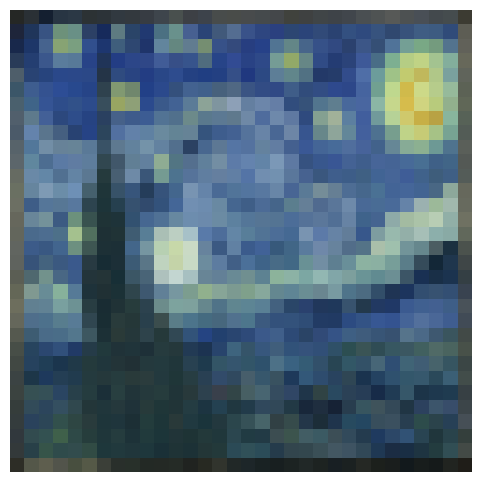

(32, 32, 3)


In [5]:
report_every_gen = 10
number_generations = 1000
polygons = 255
size = 32
target_image = "Art"


POLYGONS = polygons
SIZE = (size, size)

target_urls = utils.target_urls

target_image_url = target_urls[target_image]
target = load_target_image(target_image_url, size=SIZE)
show_image(target)
print(target.shape)

In [6]:
GENE_LENGTH = 10
NUM_GENES = POLYGONS * GENE_LENGTH

# Create individual
individual = np.random.uniform(0,1,NUM_GENES)
print(individual)

[0.09832732 0.79249874 0.83869738 ... 0.74851008 0.88266833 0.67668808]


In [7]:
def extract_genes(genes, length): 
    for i in range(0, len(genes), length): 
        yield genes[i:i + length]

In [8]:
def render_individual(individual):
  if isinstance(individual,list):
    individual = np.array(individual)
  canvas = np.zeros(SIZE+(3,))
  radius_avg = (SIZE[0] + SIZE[1]) / 2 / 6
  genes = extract_genes(individual, GENE_LENGTH)
  for gene in genes:
    try:
      overlay = canvas.copy()
      x1 = int(gene[0] * SIZE[0])
      x2 = int(gene[2] * SIZE[0])
      x3 = int(gene[4] * SIZE[0])
      y1 = int(gene[1] * SIZE[1])
      y2 = int(gene[3] * SIZE[1])
      y3 = int(gene[5] * SIZE[1])
      color = (gene[6:-1] * 255).astype(int).tolist() 
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]], np.int32)  
      pts = pts.reshape((-1, 1, 2))
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]])

      cv2.fillPoly(overlay, [pts], color)
      alpha = gene[-1]
      canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)  
    except:
      pass
  return canvas

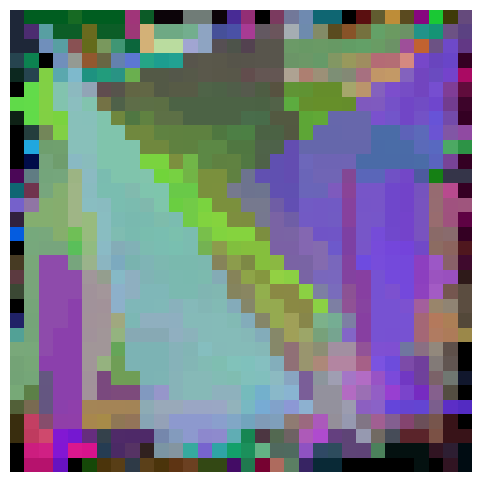

In [9]:
# Show individual
render = render_individual(individual)
show_image(render)

### Metrics

In [10]:
def fitness_mse(render):
  """Calculates Mean Square Error Fitness for a render"""
  error = (np.square(render - target)).mean(axis=None)
  return error

In [11]:
def fitness_ss(render):
  """Calculated Structural Similiarity Fitness"""
  index = ss(render, target, multichannel=True)
  return 1-index

In [12]:
print(fitness_mse(render))

4648.854672485712


In [13]:
# Apply Hyperparameters
IND_SIZE = NUM_GENES


CXPB = .6
MUTPB = .3

MIN_VALUE = -1
MAX_VALUE = 1
MIN_STRATEGY = 0.5
MAX_STRATEGY = 5

### Setting up creator

In [14]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", list, typecode="d")

In [15]:

def generateES(icls, scls, size, imin, imax, smin, smax):  
  ind = icls(random.uniform(imin, imax) for _ in range(size))  
  ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))  
  return ind

def checkStrategy(minstrategy):
  def decorator(func):
    def wrappper(*args, **kargs):
      children = func(*args, **kargs)
      for child in children:
        for i, s in enumerate(child.strategy):
          if s < minstrategy:
            child.strategy[i] = minstrategy
      return children
    return wrappper
  return decorator

In [16]:

def uniform(low, up, size=None):
  try:
    return [random.uniform(a, b) for a, b in zip(low, up)]
  except TypeError:
    return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [17]:

def clamp(low, up, n):
  return max(low, min(n, up))

def custom_blend(ind1, ind2, alpha):    
    for i, (x1, s1, x2, s2) in enumerate(zip(ind1, ind1.strategy,
                                             ind2, ind2.strategy)):
        # Blend the values
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1[i] = clamp(0.0, 1.0, (1. - gamma) * x1 + gamma * x2)
        ind2[i] = clamp(0.0, 1.0, gamma * x1 + (1. - gamma) * x2)
        # Blend the strategies
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1.strategy[i] = (1. - gamma) * s1 + gamma * s2
        ind2.strategy[i] = gamma * s1 + (1. - gamma) * s2
        

    return ind1, ind2

In [18]:
toolbox = base.Toolbox()
toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRATEGY, MAX_STRATEGY)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", custom_blend, alpha=0.5)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.06)

# This function is used to select individuals from the population based on their fitness.
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.decorate("mate", checkStrategy(MIN_STRATEGY))
toolbox.decorate("mutate", checkStrategy(MIN_STRATEGY))

In [19]:

# Evaluate individuals
def evaluate(individual):
  render = render_individual(individual)
  print('.', end='')
  return fitness_mse(render),

In [20]:
toolbox.register("evaluate", evaluate) # Evaluate

In [21]:

random.seed(64)
    
NGEN = number_generations
RGEN = report_every_gen
CXPB = .6
MUTPB = .3
MU, LAMBDA = 100, 250
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

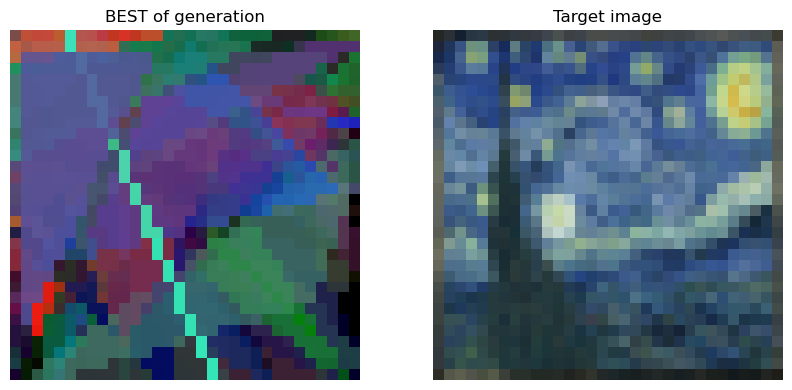

Gen (10) : best fitness = 2353.7443968529274
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

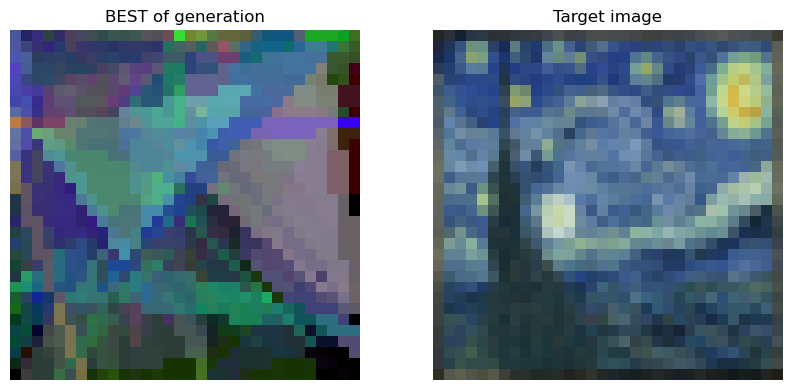

Gen (20) : best fitness = 1797.1244451376817
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

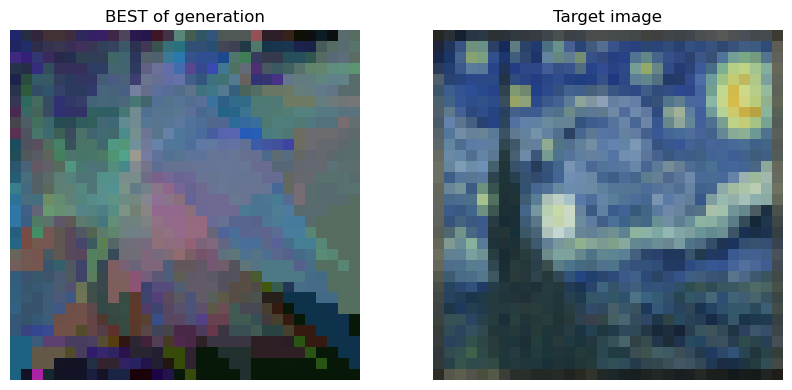

Gen (30) : best fitness = 1324.7742964045242
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

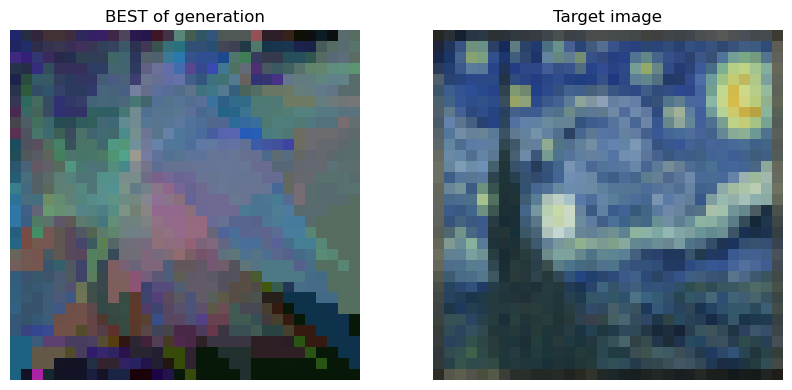

Gen (40) : best fitness = 1324.7742964045242
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

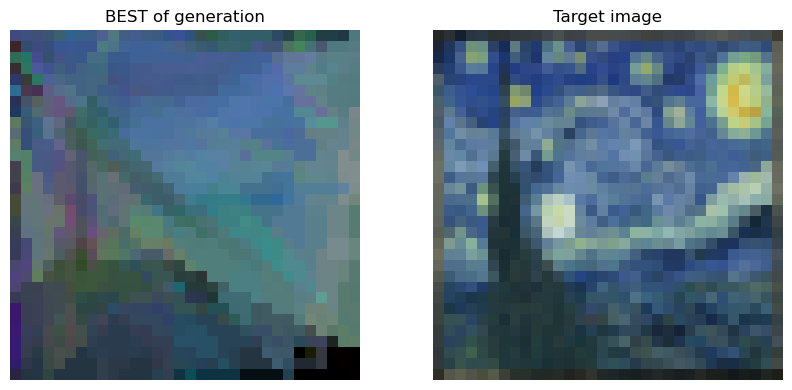

Gen (50) : best fitness = 1141.518423955588
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

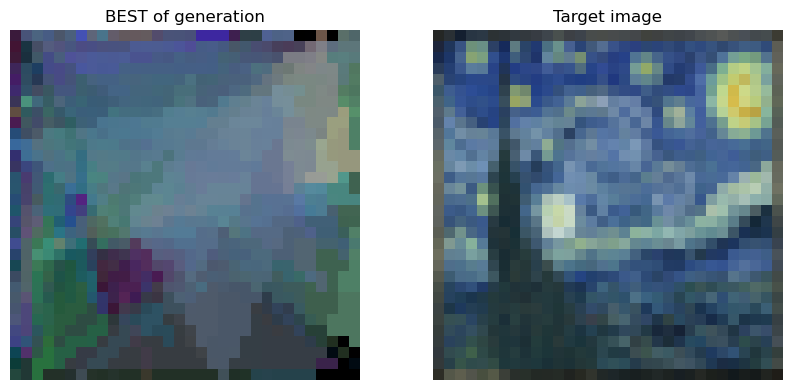

Gen (60) : best fitness = 1019.1626822294833
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

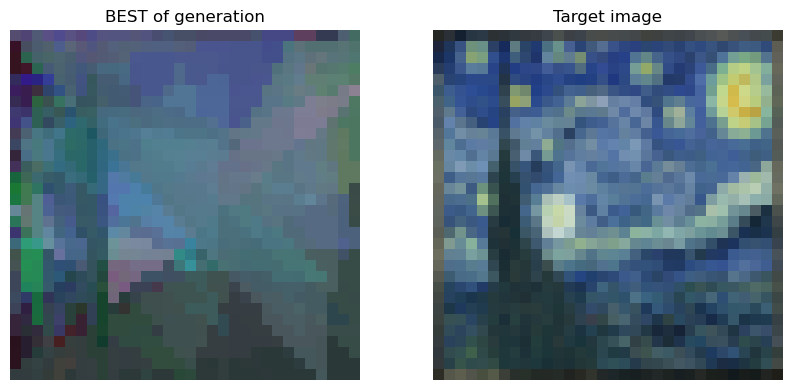

Gen (70) : best fitness = 945.4260348626422
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

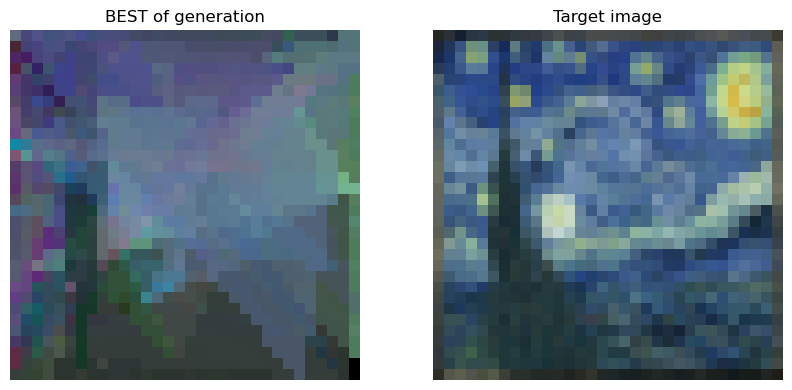

Gen (80) : best fitness = 861.0867156837949
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

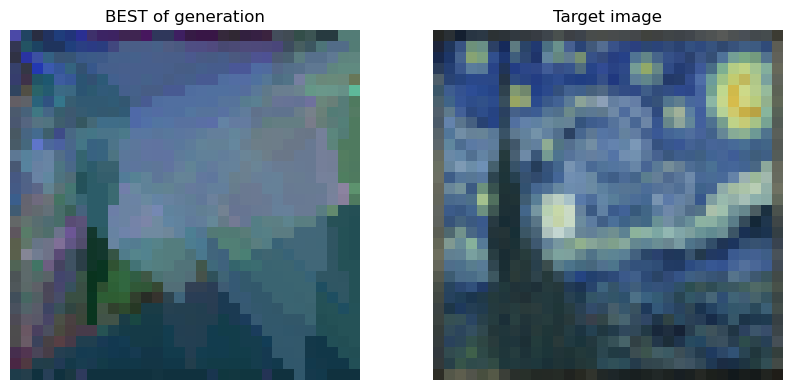

Gen (90) : best fitness = 774.1707982915012
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

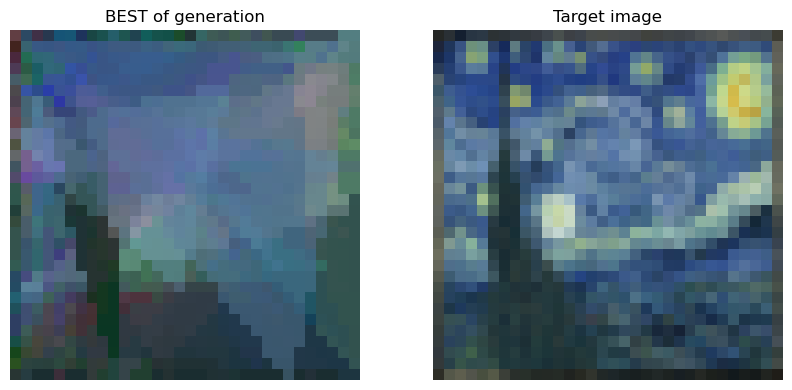

Gen (100) : best fitness = 735.1799565518683
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

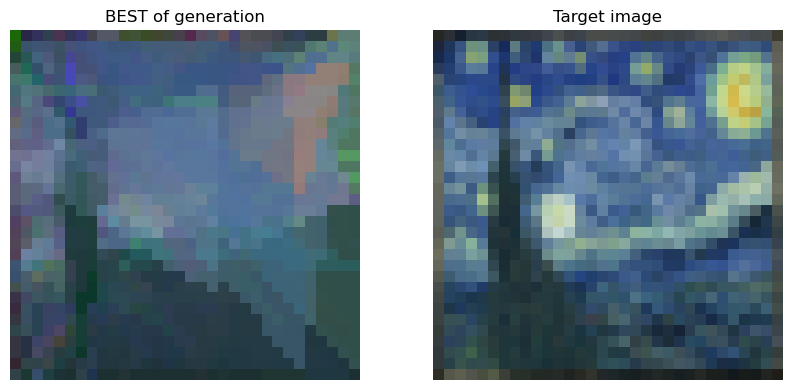

Gen (110) : best fitness = 698.3663492950012
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

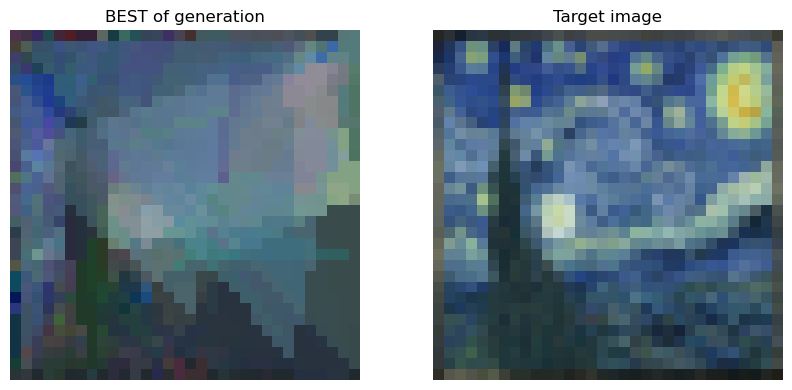

Gen (120) : best fitness = 670.6551307429949
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

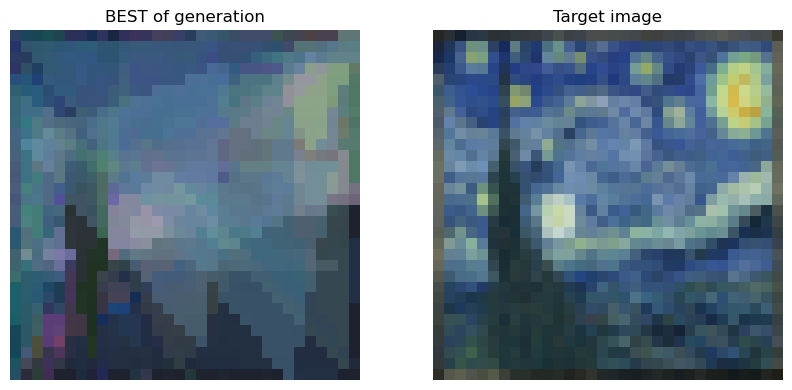

Gen (130) : best fitness = 644.0610691411954
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

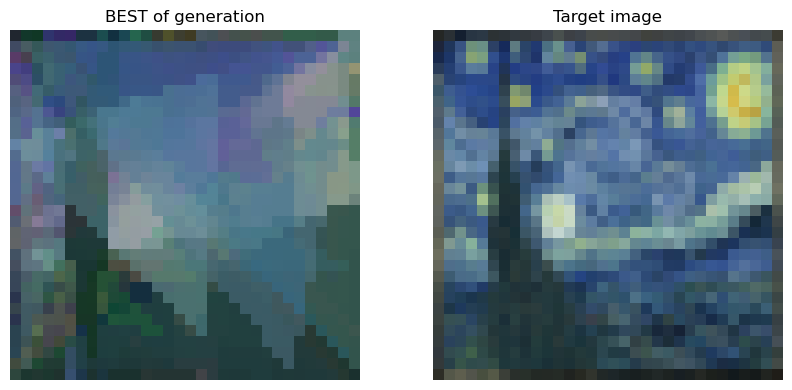

Gen (140) : best fitness = 623.1824340334409
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

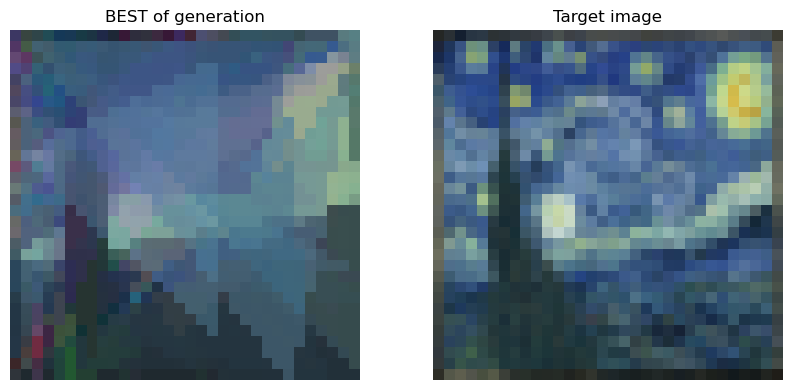

Gen (150) : best fitness = 600.6691868888051
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

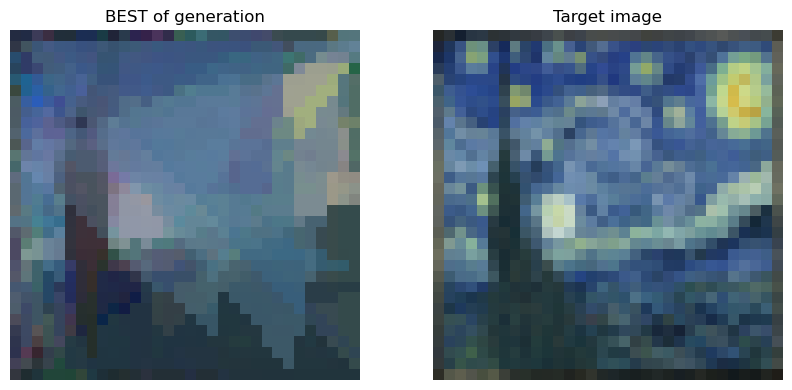

Gen (160) : best fitness = 574.1816750458853
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

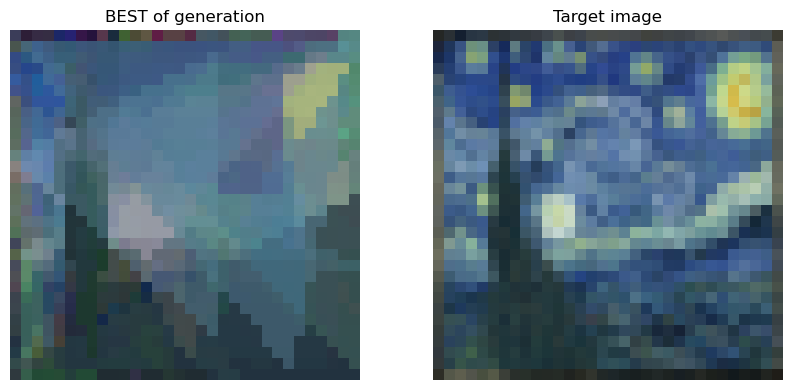

Gen (170) : best fitness = 553.1665142268367
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

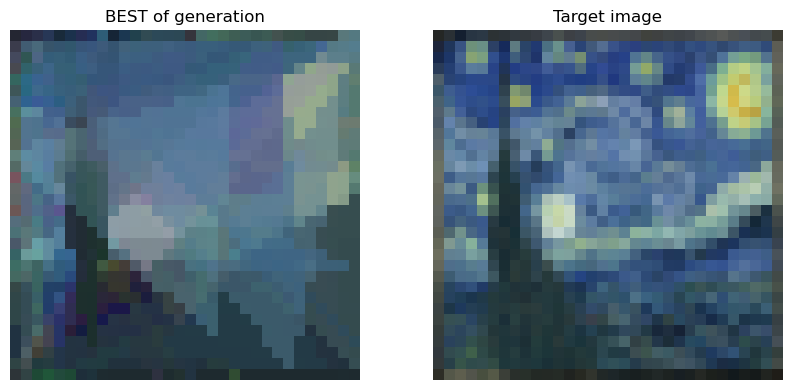

Gen (180) : best fitness = 536.7442608423947
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

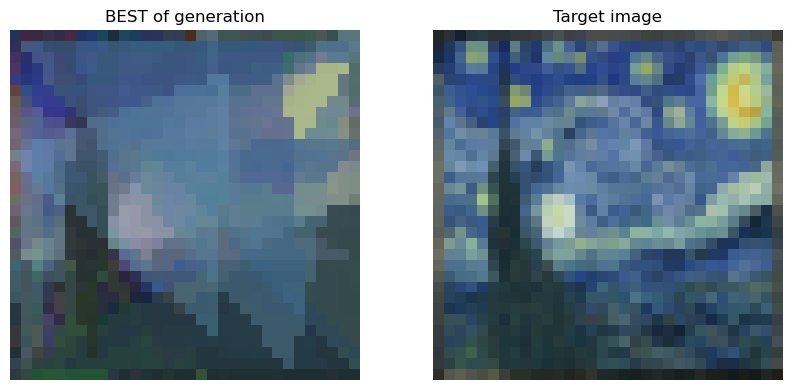

Gen (190) : best fitness = 507.45549534165804
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

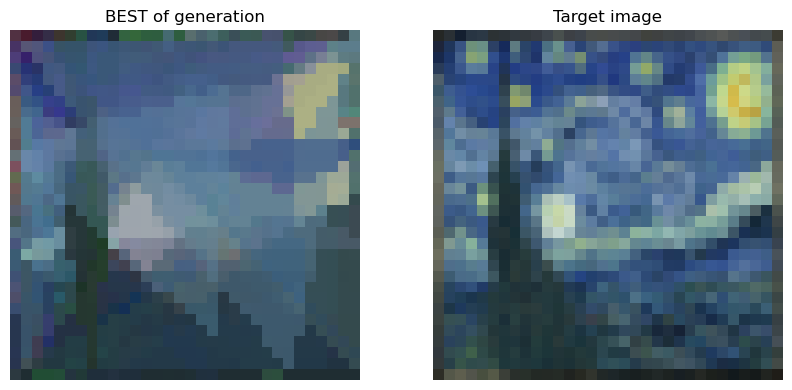

Gen (200) : best fitness = 497.2392155704071
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

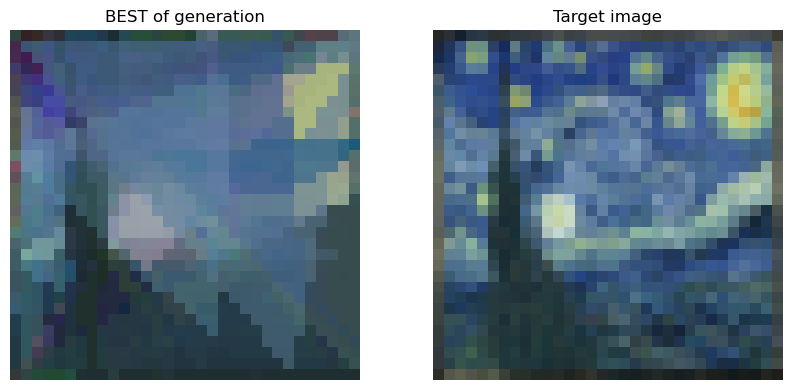

Gen (210) : best fitness = 481.91445795009344
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

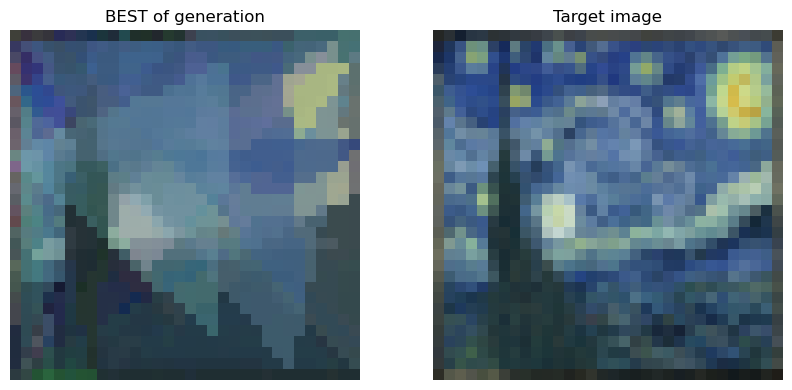

Gen (220) : best fitness = 469.95211186053547
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

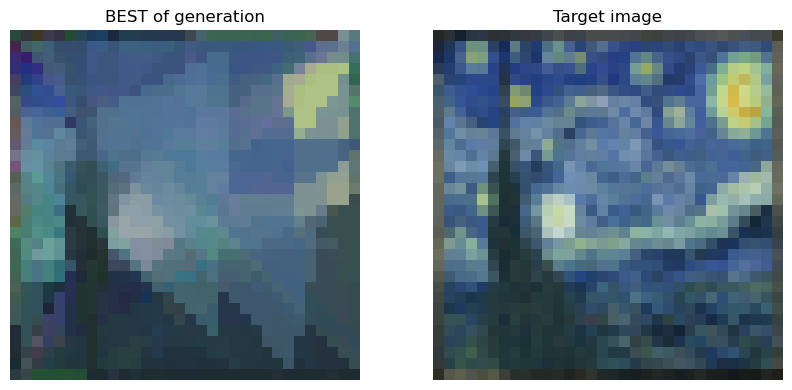

Gen (230) : best fitness = 458.83734882958487
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

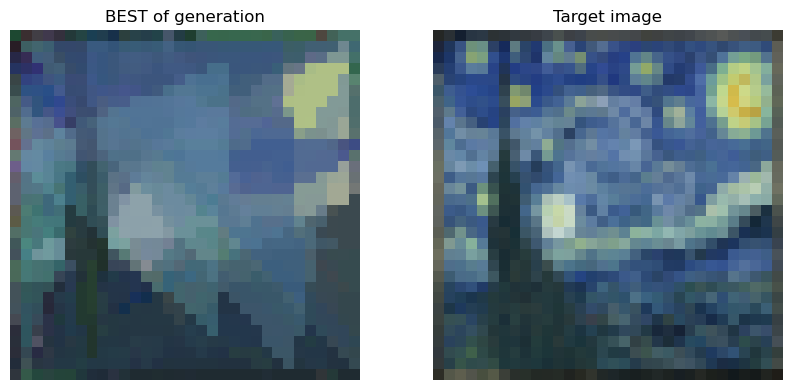

Gen (240) : best fitness = 443.4009721513621
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

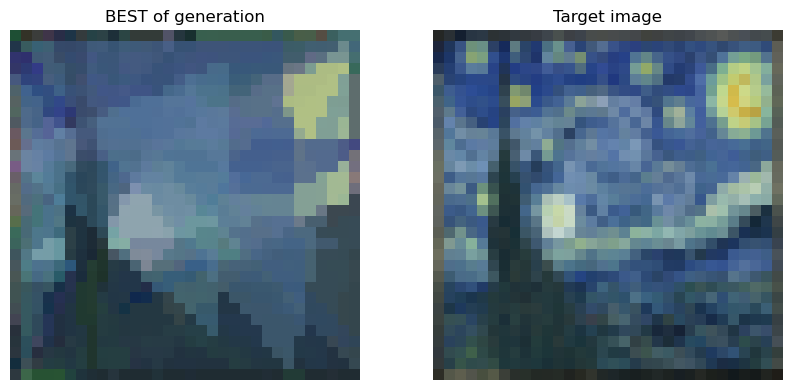

Gen (250) : best fitness = 432.7935527618374
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

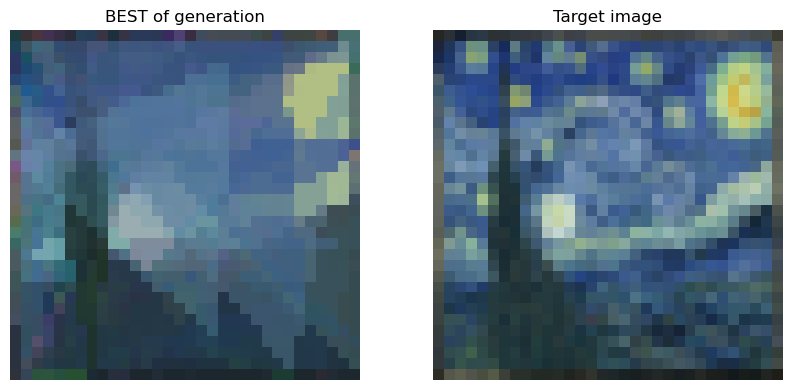

Gen (260) : best fitness = 420.46915667992306
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

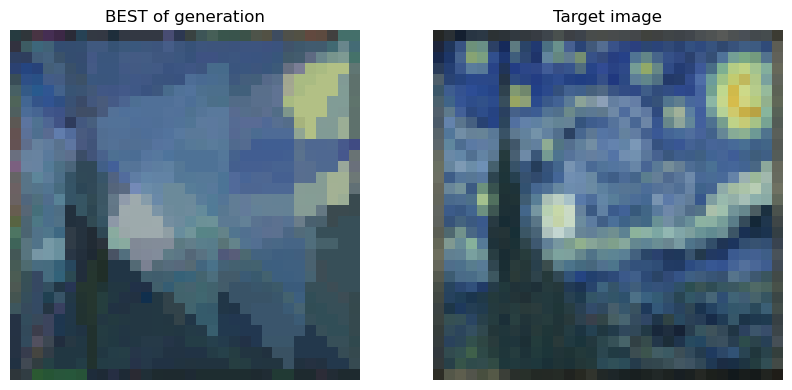

Gen (270) : best fitness = 410.680671183628
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

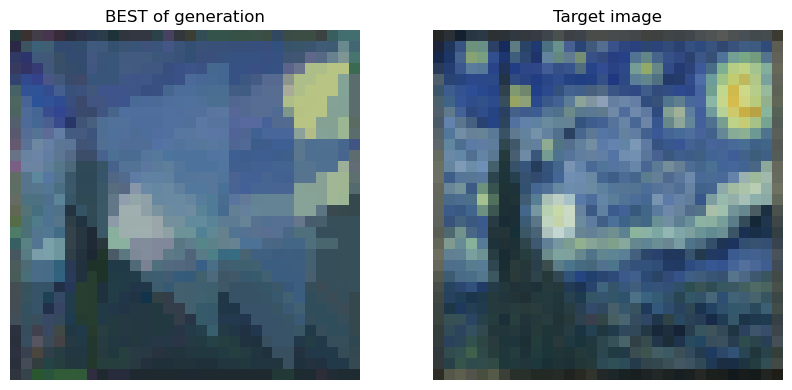

Gen (280) : best fitness = 403.5928150431032
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

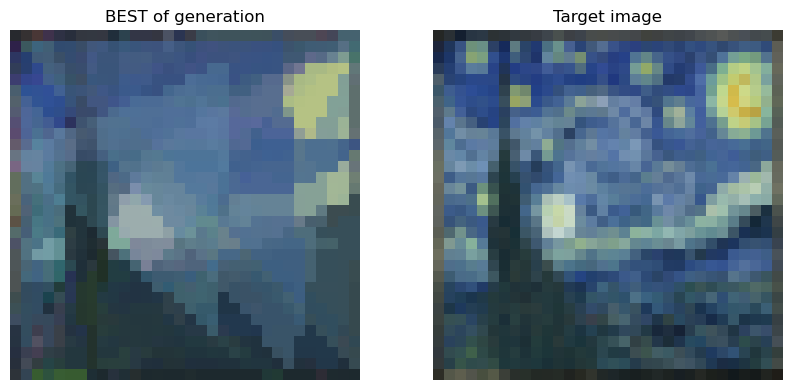

Gen (290) : best fitness = 397.17973073775937
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

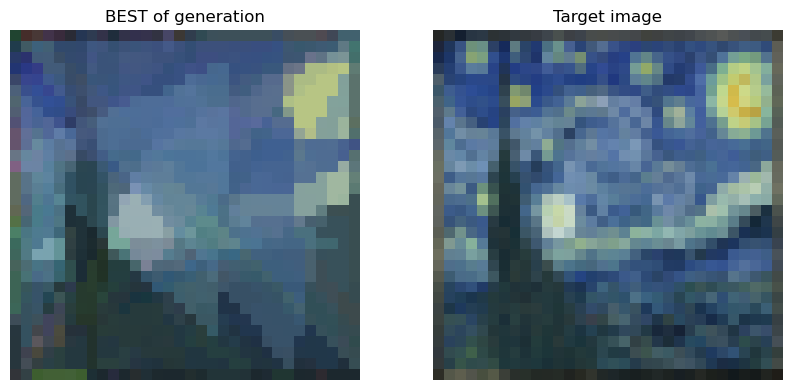

Gen (300) : best fitness = 395.29727148685953
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

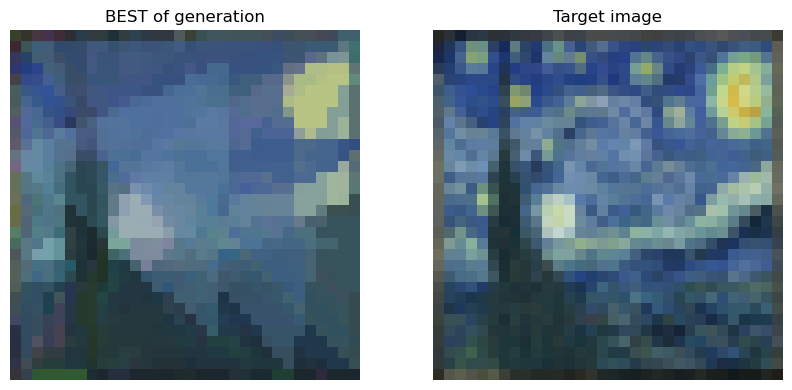

Gen (310) : best fitness = 389.52069204791724
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

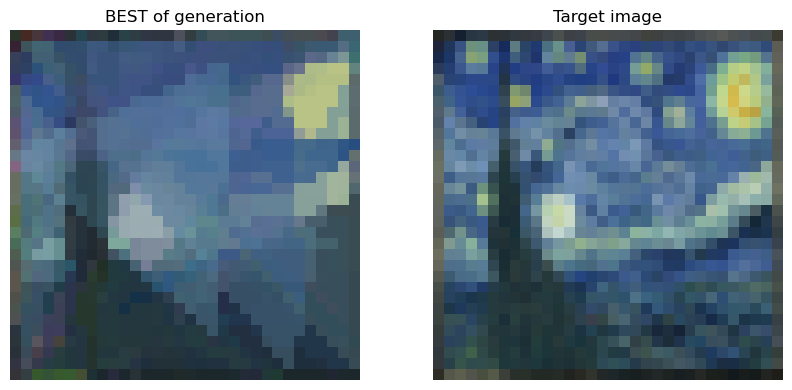

Gen (320) : best fitness = 386.2837912812536
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

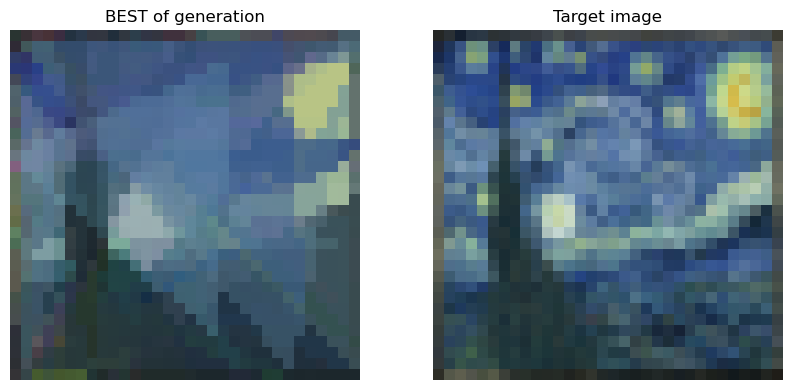

Gen (330) : best fitness = 381.50561841690563
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

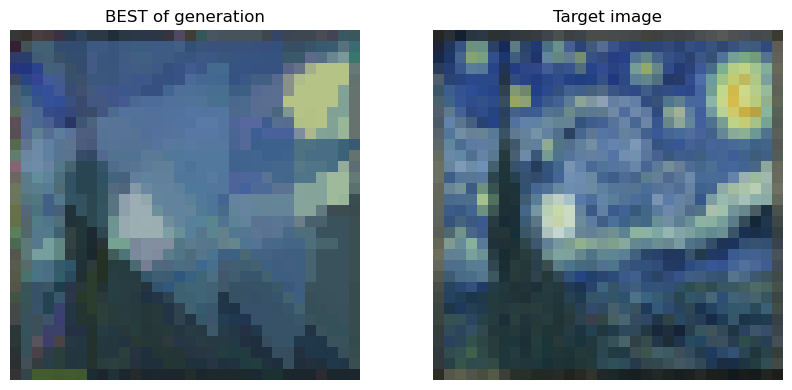

Gen (340) : best fitness = 376.99613516931964
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

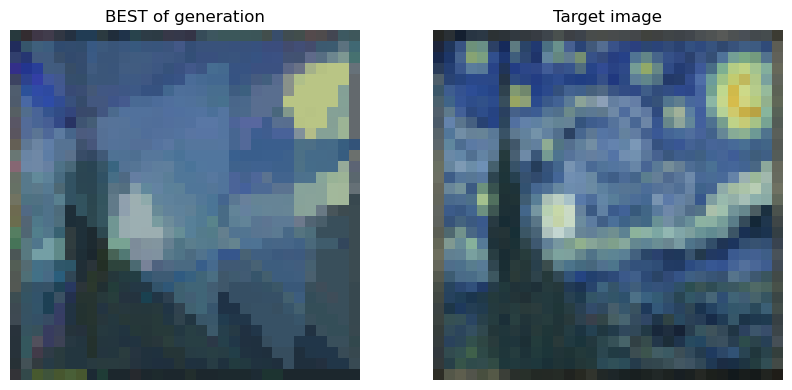

Gen (350) : best fitness = 371.15182277305456
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

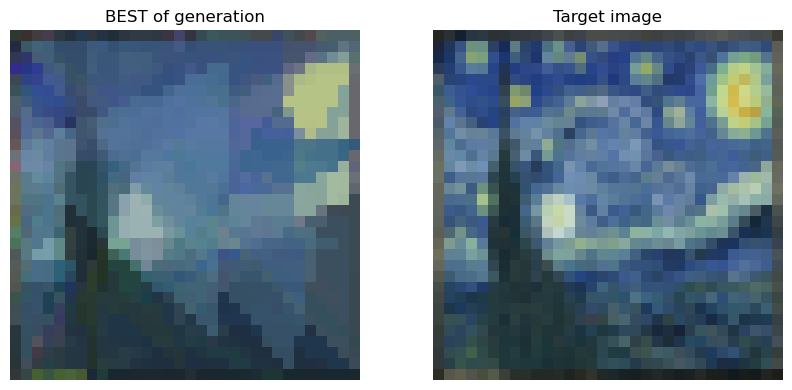

Gen (360) : best fitness = 366.91932029040225
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

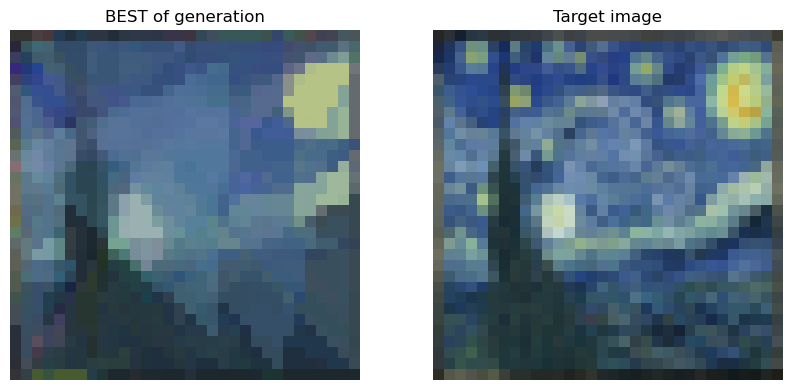

Gen (370) : best fitness = 360.07495450013886
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

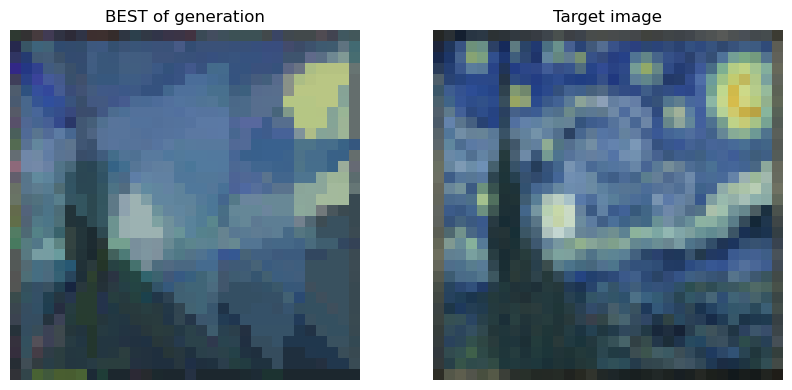

Gen (380) : best fitness = 356.4403707802043
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

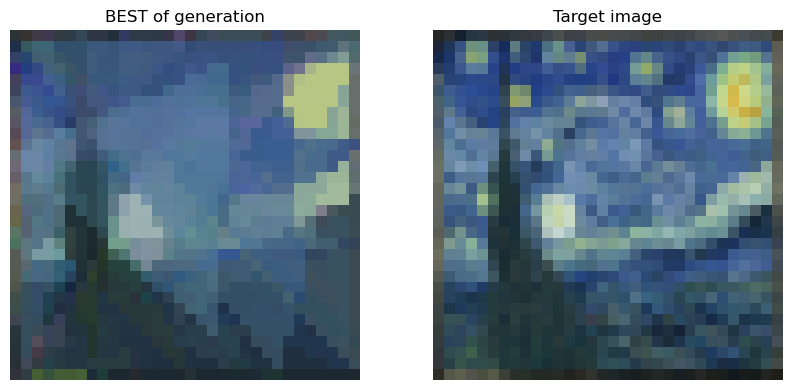

Gen (390) : best fitness = 352.36902711097235
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

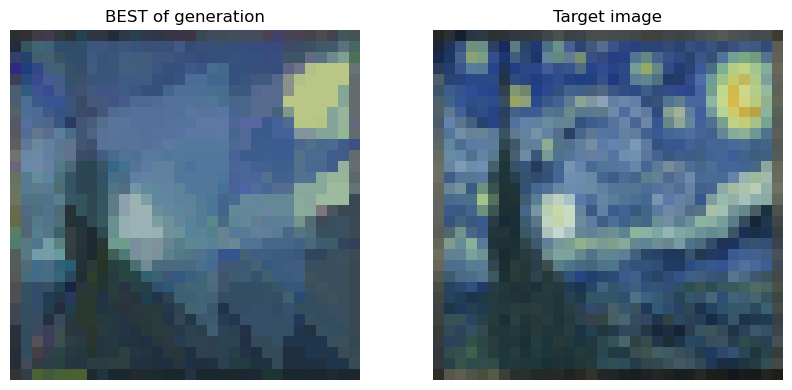

Gen (400) : best fitness = 350.6282773605664
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

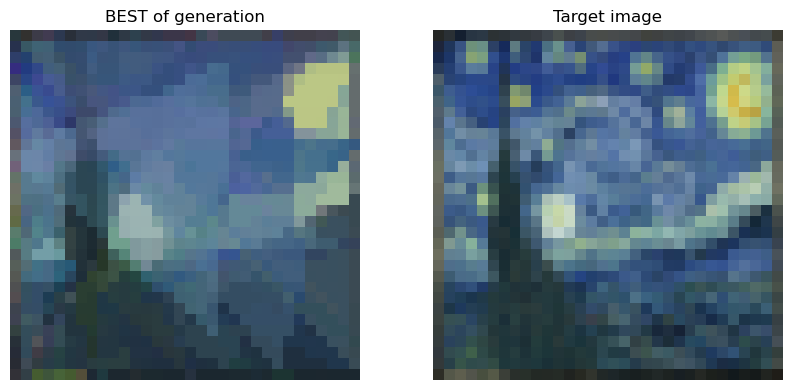

Gen (410) : best fitness = 347.07397683005576
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

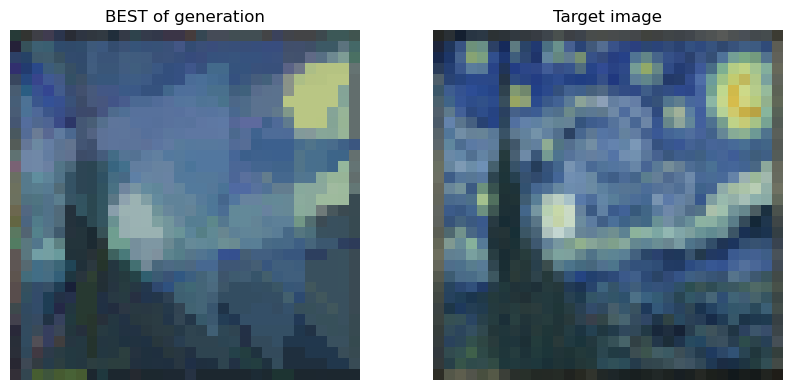

Gen (420) : best fitness = 342.942640944503
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

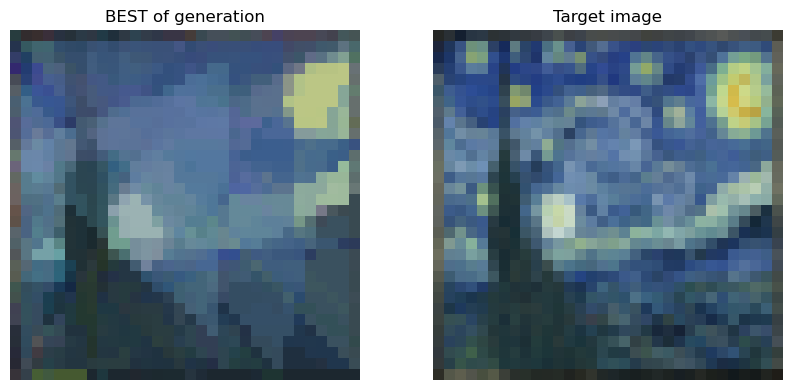

Gen (430) : best fitness = 339.0652339415808
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

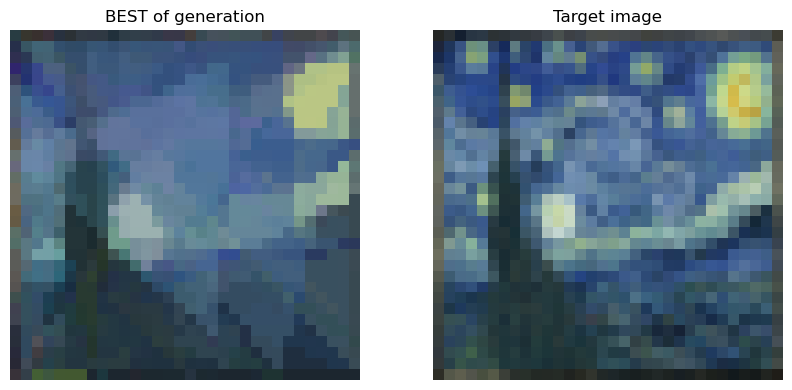

Gen (440) : best fitness = 334.1554532088638
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

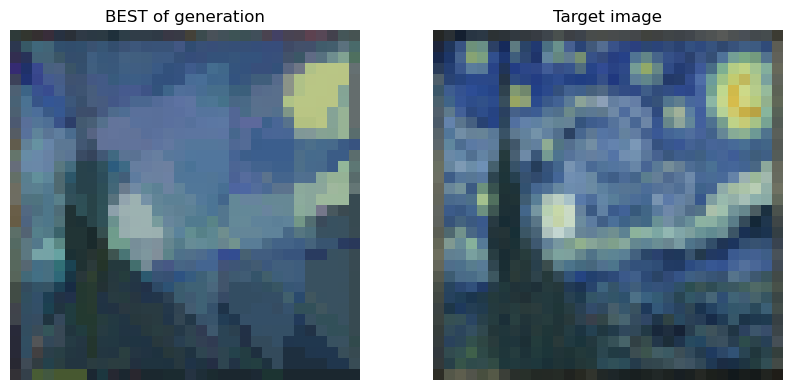

Gen (450) : best fitness = 333.2231481021319
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

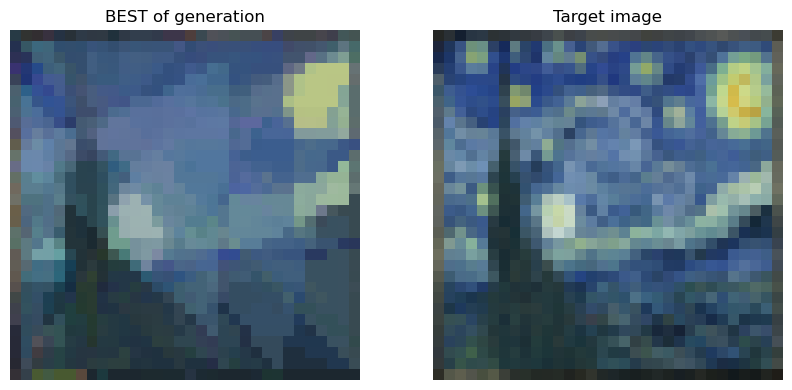

Gen (460) : best fitness = 331.41985272948517
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

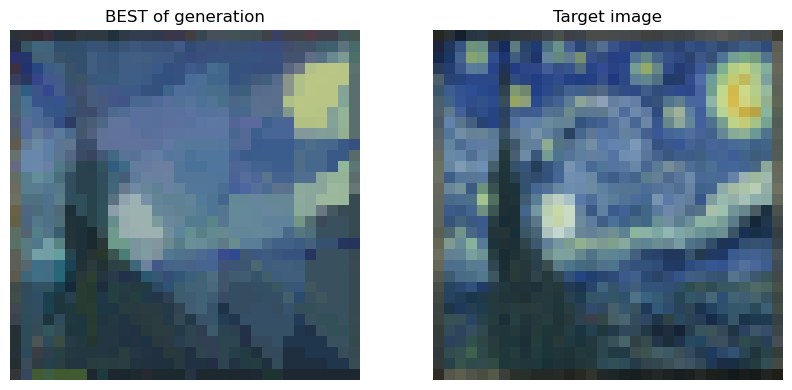

Gen (470) : best fitness = 329.8197826111457
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

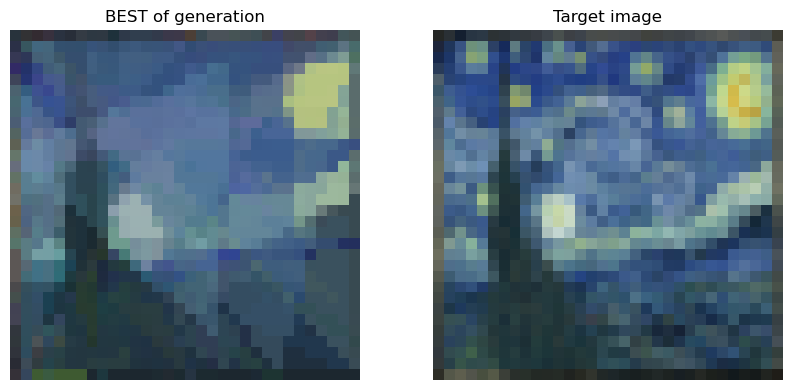

Gen (480) : best fitness = 328.2561318102562
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

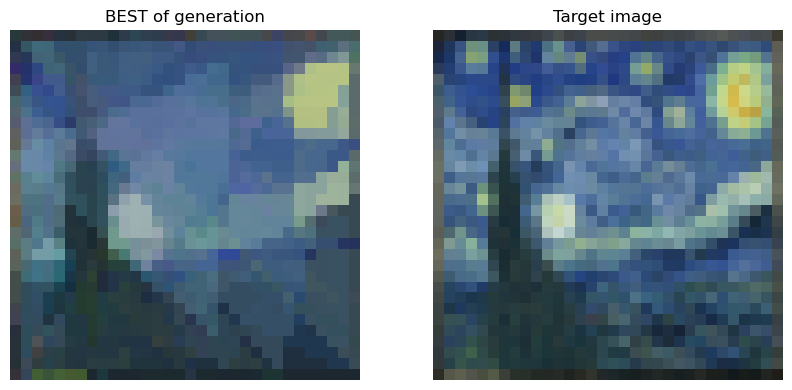

Gen (490) : best fitness = 325.93804769805257
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

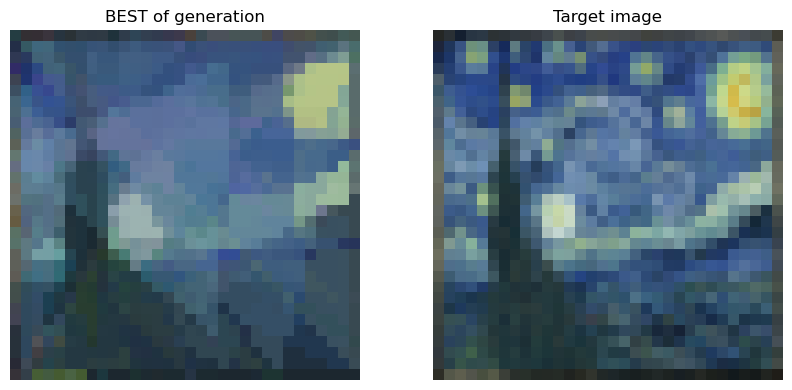

Gen (500) : best fitness = 323.4324795760287
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

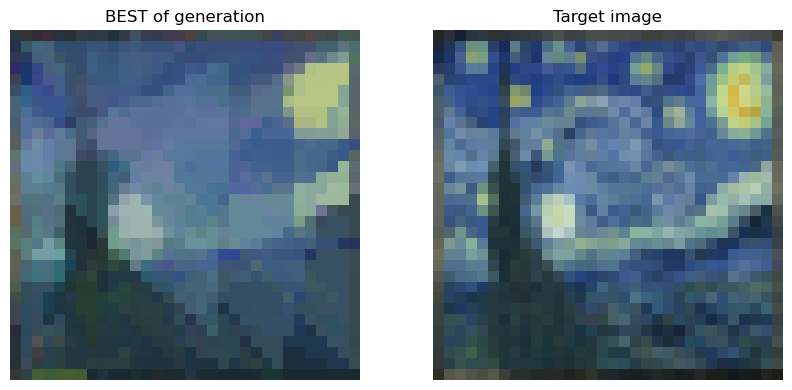

Gen (510) : best fitness = 321.2672177654403
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

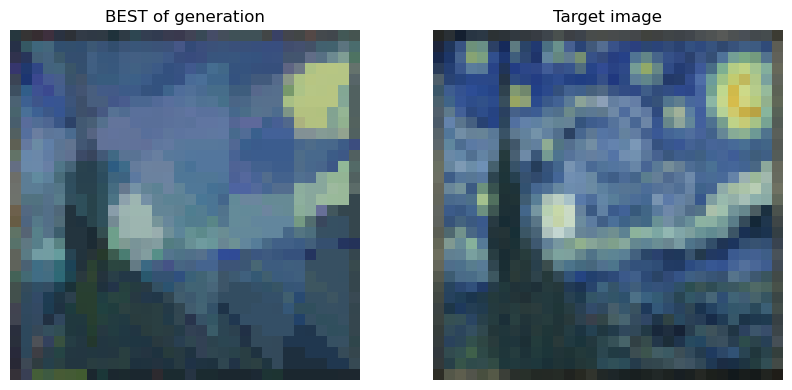

Gen (520) : best fitness = 317.6138321905523
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

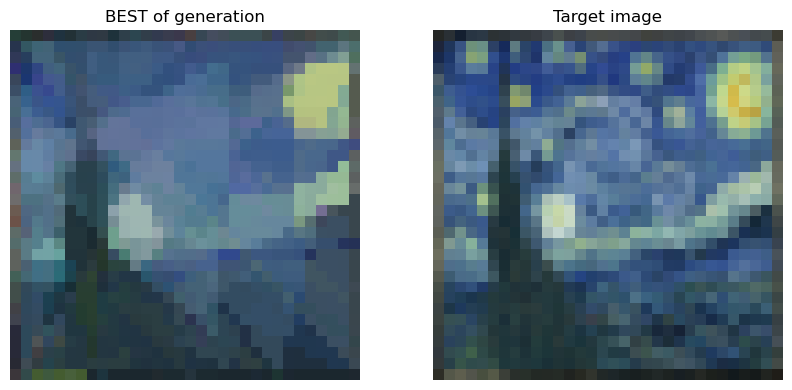

Gen (530) : best fitness = 317.08500826594997
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

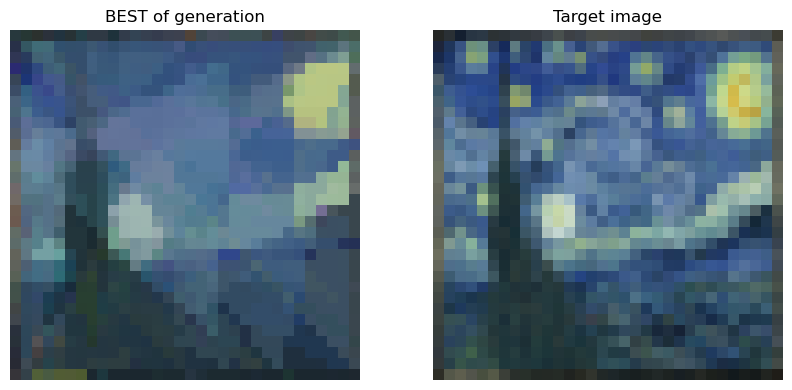

Gen (540) : best fitness = 314.7708228333286
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

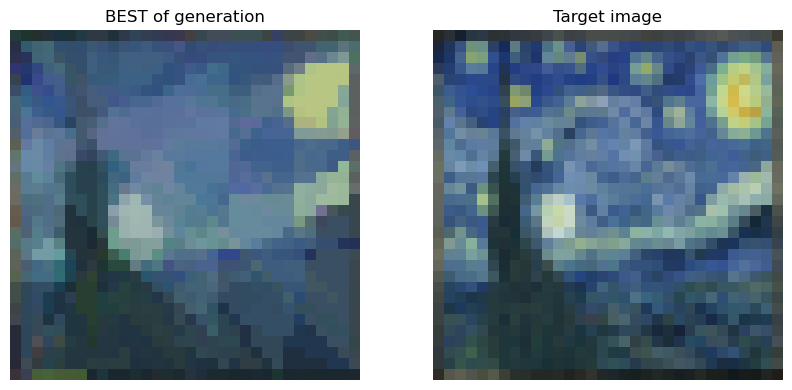

Gen (550) : best fitness = 313.00526353625423
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

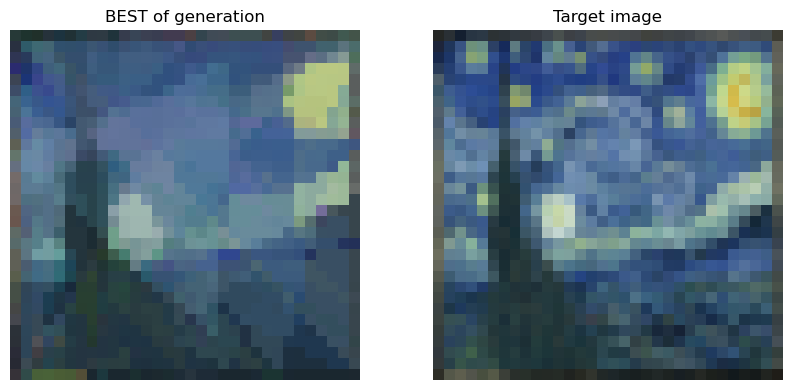

Gen (560) : best fitness = 311.38025500938056
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

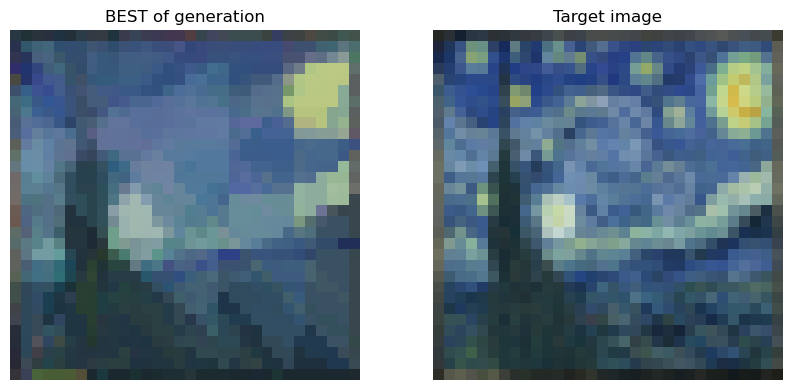

Gen (570) : best fitness = 310.0220888281967
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

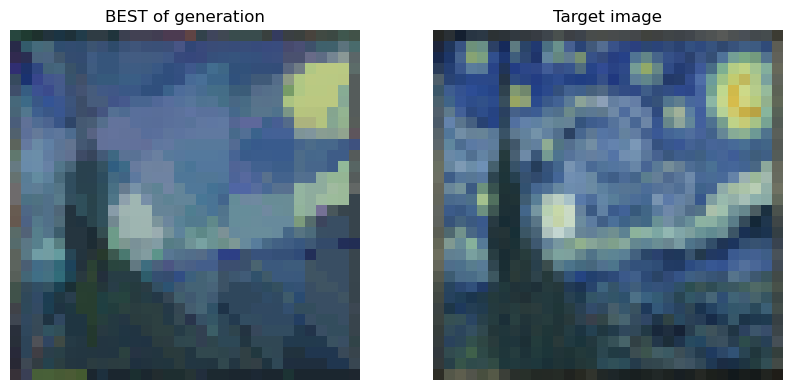

Gen (580) : best fitness = 307.8016802959281
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

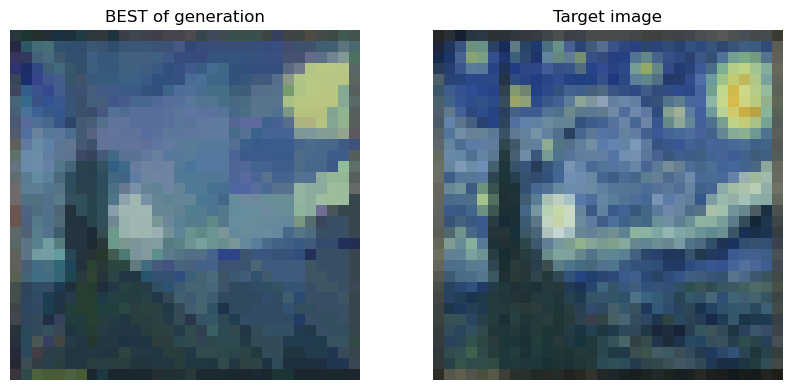

Gen (590) : best fitness = 307.37644404094044
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

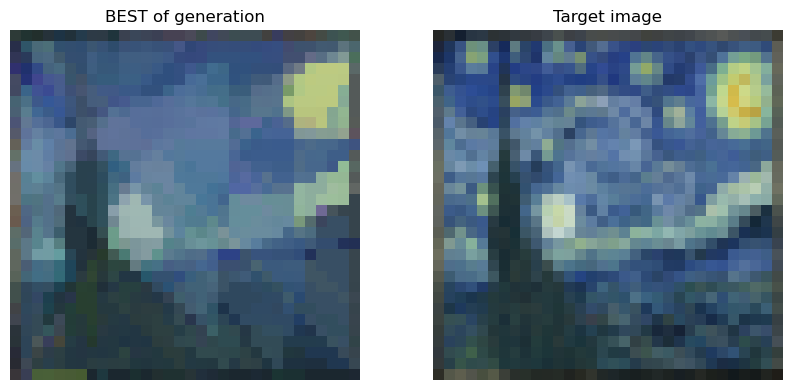

Gen (600) : best fitness = 306.00072141965444
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

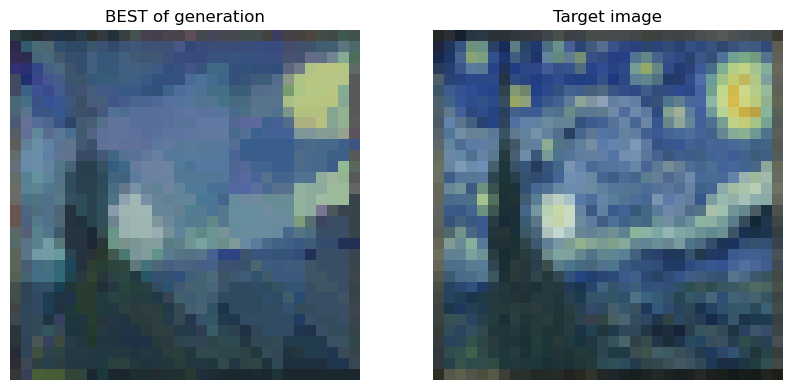

Gen (610) : best fitness = 304.6489988447284
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

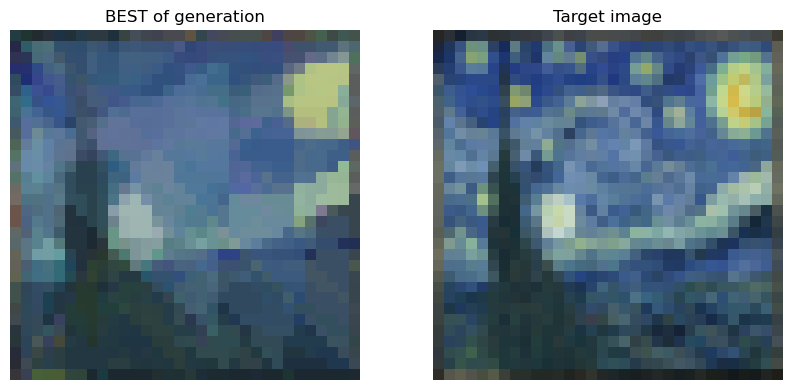

Gen (620) : best fitness = 303.24391313001456
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

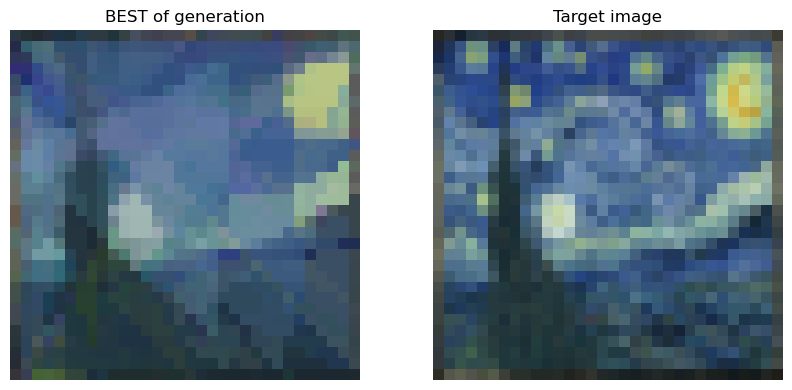

Gen (630) : best fitness = 301.90175322816833
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

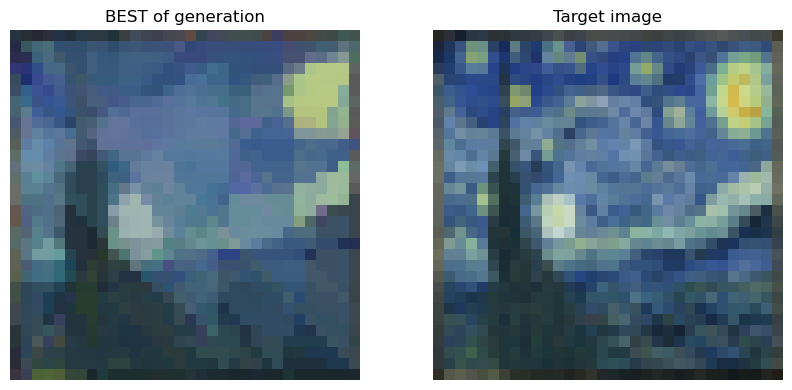

Gen (640) : best fitness = 300.9322264840098
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

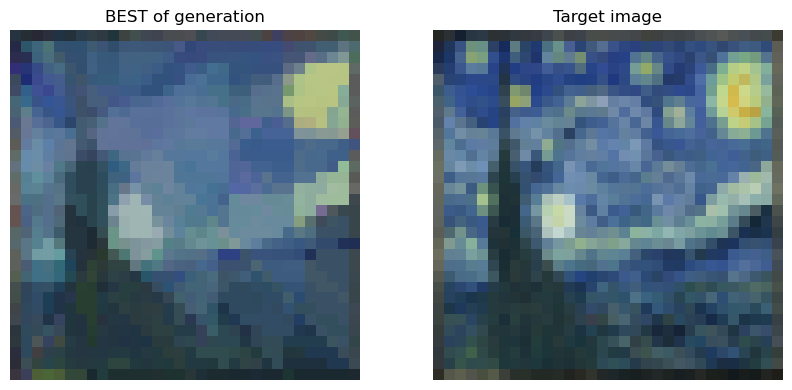

Gen (650) : best fitness = 299.40904083988676
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

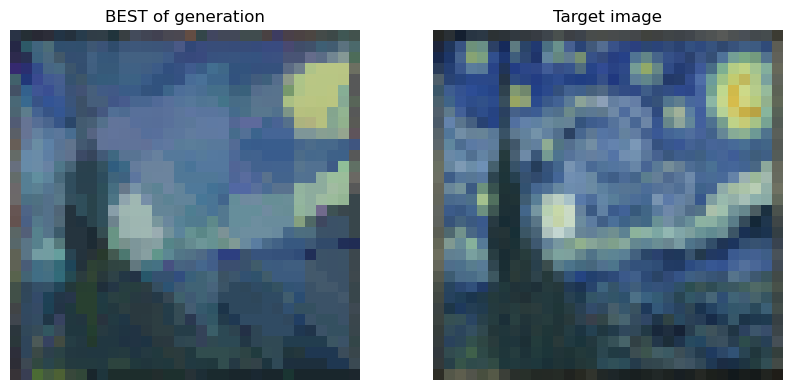

Gen (660) : best fitness = 297.70323975291626
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

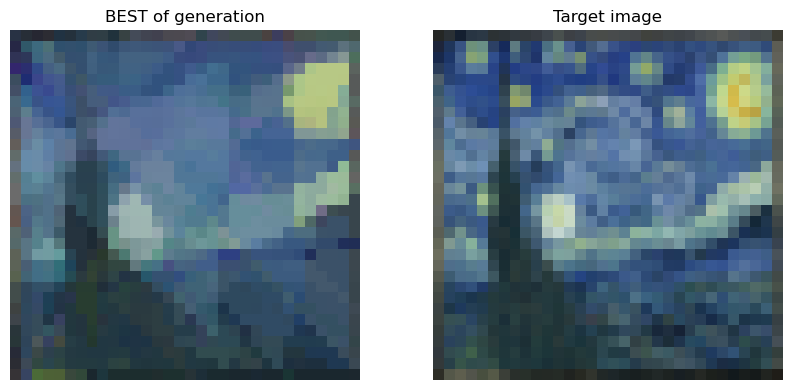

Gen (670) : best fitness = 296.69878173654024
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

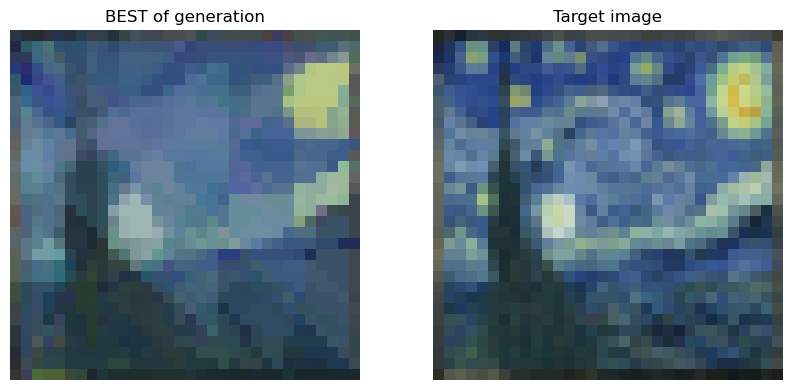

Gen (680) : best fitness = 295.3673249643837
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

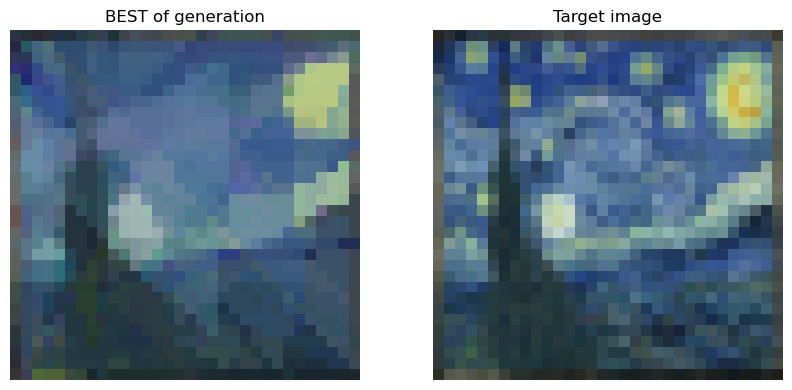

Gen (690) : best fitness = 294.3062948512033
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

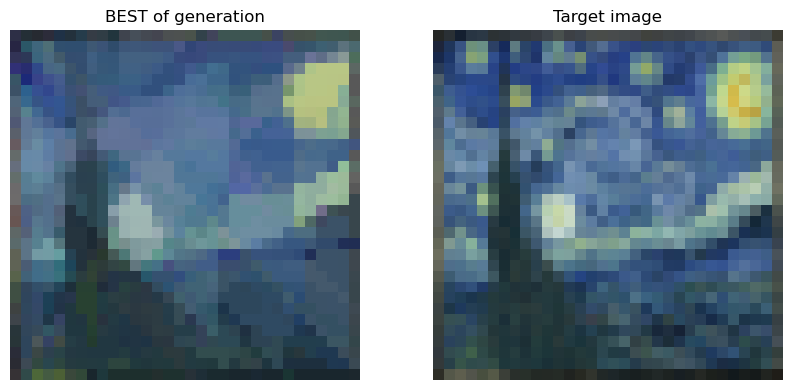

Gen (700) : best fitness = 293.18689244405334
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

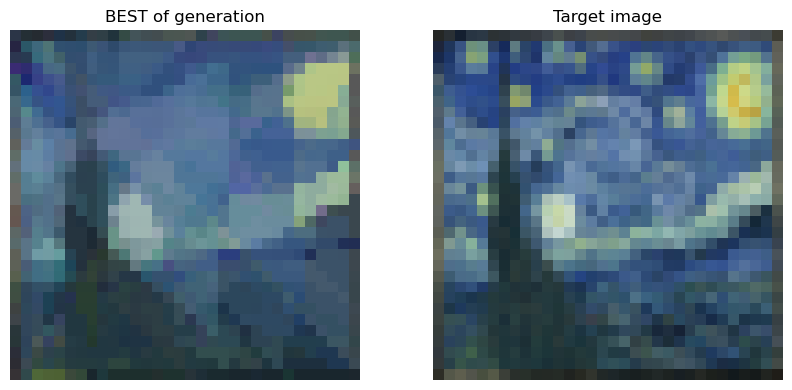

Gen (710) : best fitness = 292.3289542744444
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

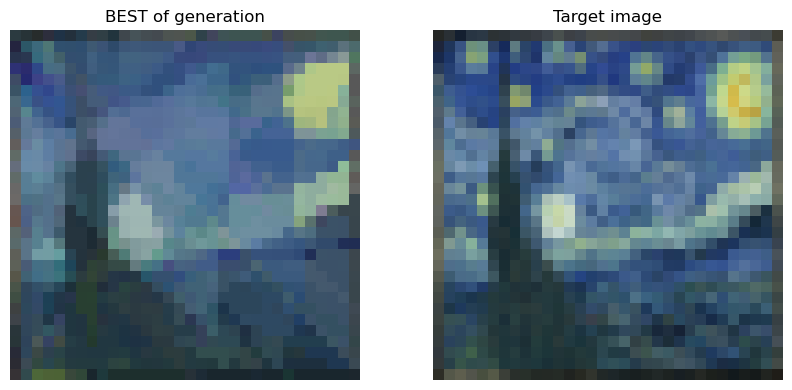

Gen (720) : best fitness = 291.41437780269507
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

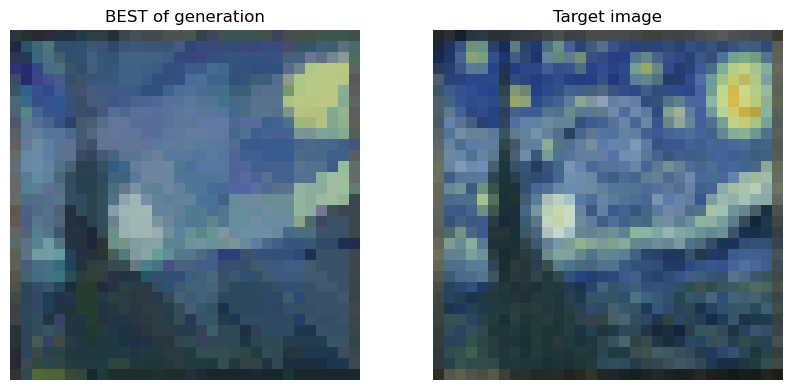

Gen (730) : best fitness = 290.7922127263718
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

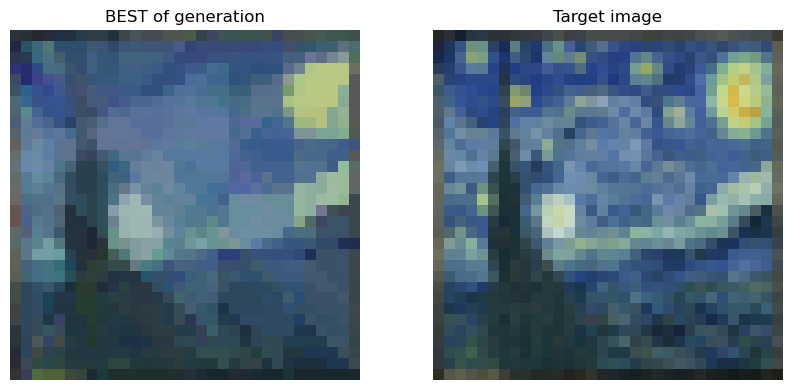

Gen (740) : best fitness = 289.9095826178274
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

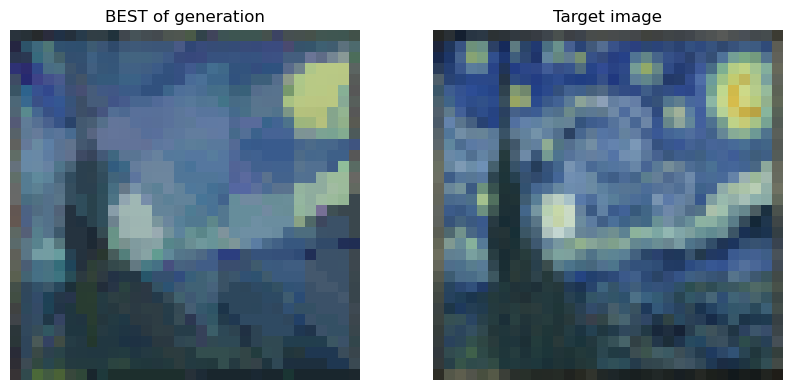

Gen (750) : best fitness = 289.6090675465127
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

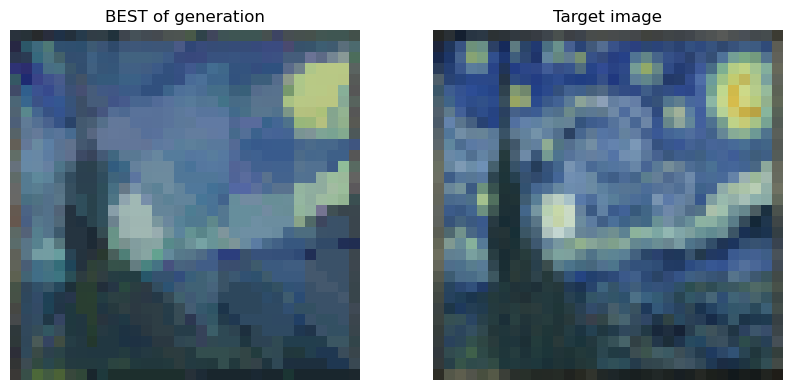

Gen (760) : best fitness = 289.13670203875523
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

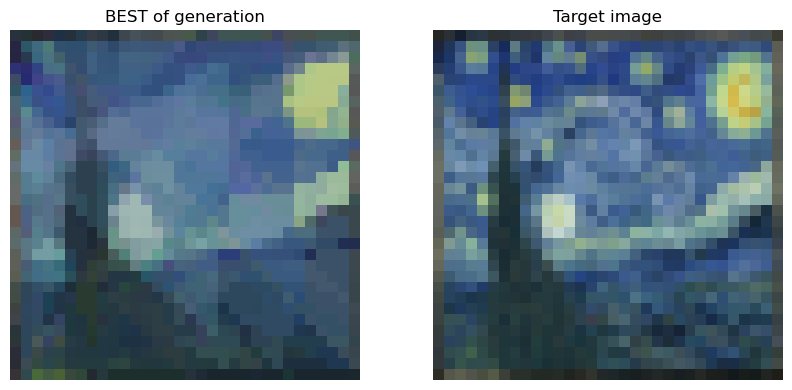

Gen (770) : best fitness = 288.5596792745761
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

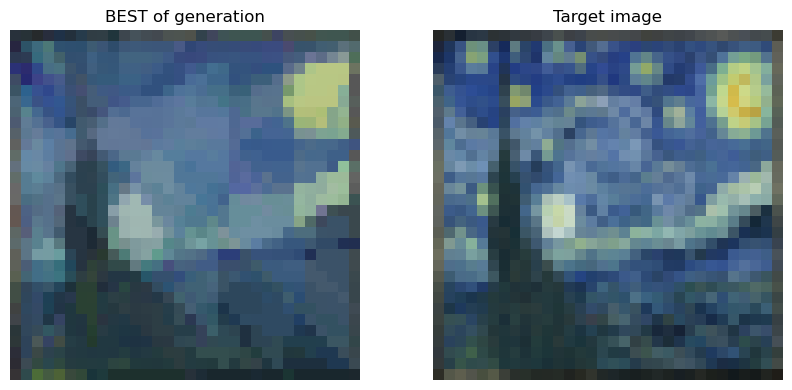

Gen (780) : best fitness = 288.1024291100339
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

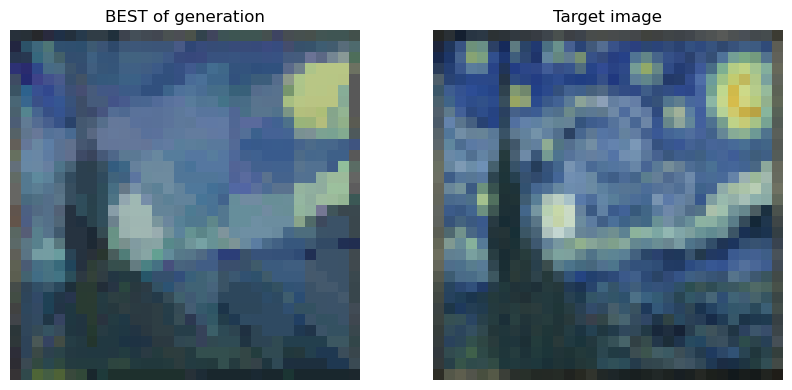

Gen (790) : best fitness = 287.6873719031589
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

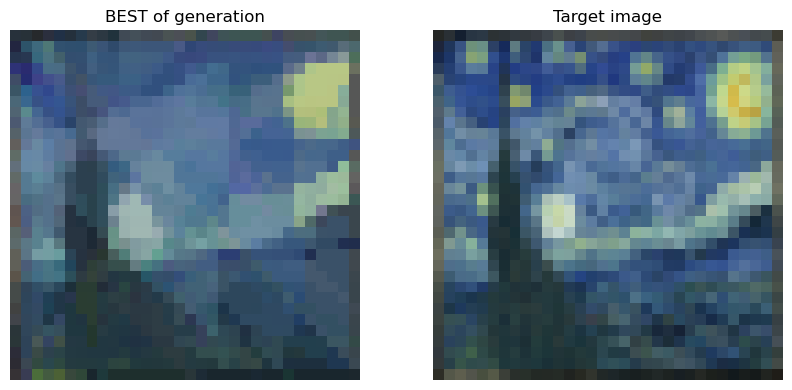

Gen (800) : best fitness = 286.92628942673787
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

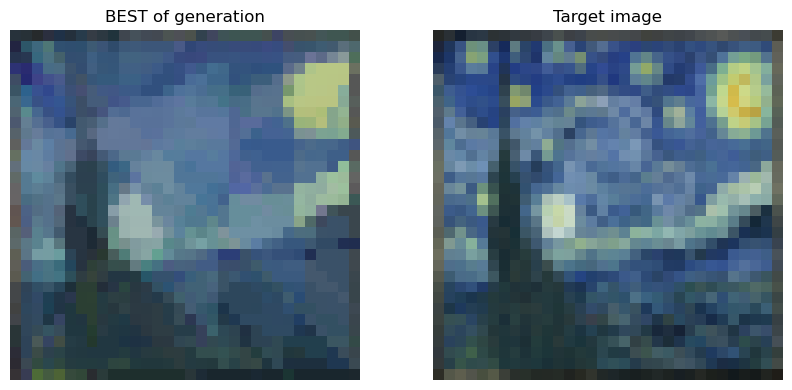

Gen (810) : best fitness = 286.3478516077835
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

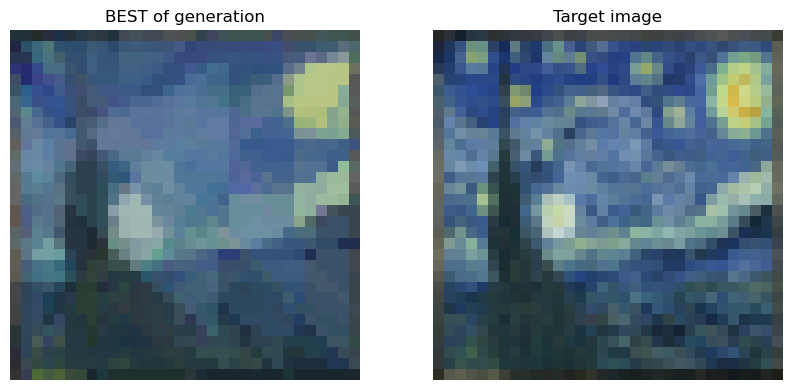

Gen (820) : best fitness = 285.5242862820393
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

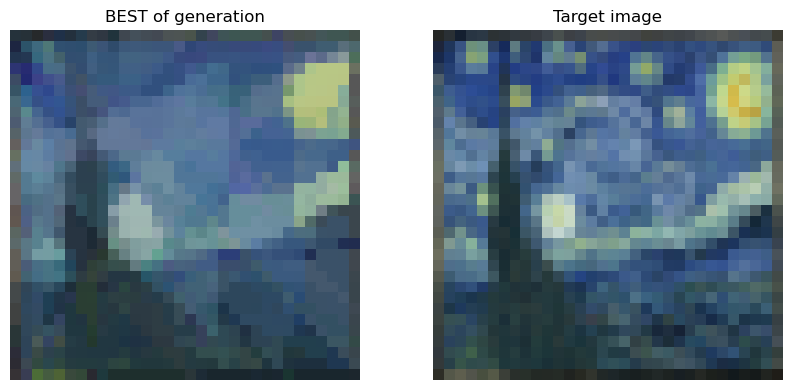

Gen (830) : best fitness = 285.11070567453913
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

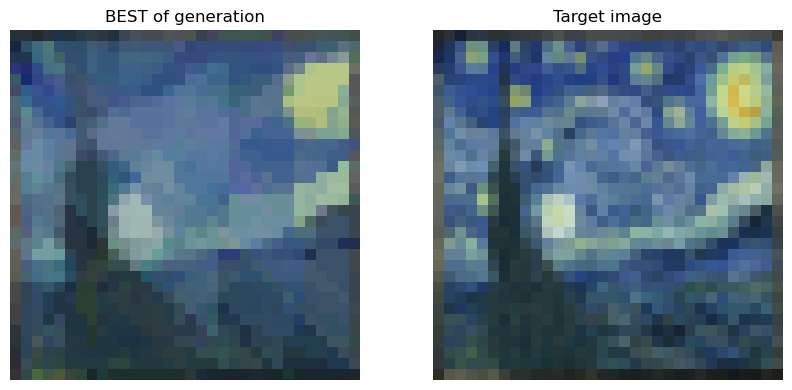

Gen (840) : best fitness = 283.9555632784051
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

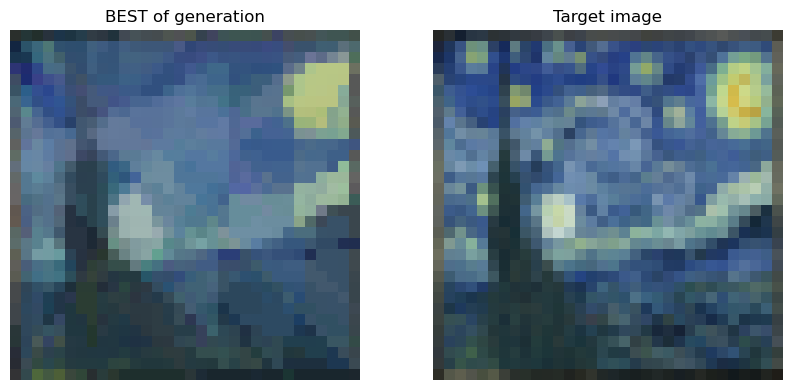

Gen (850) : best fitness = 283.53576034792314
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

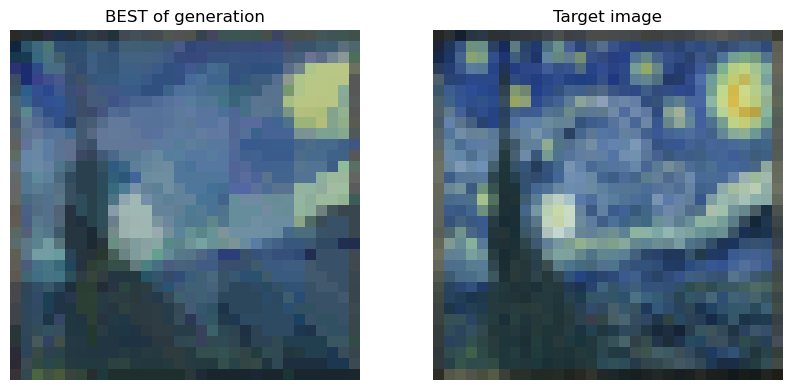

Gen (860) : best fitness = 282.8503784409197
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

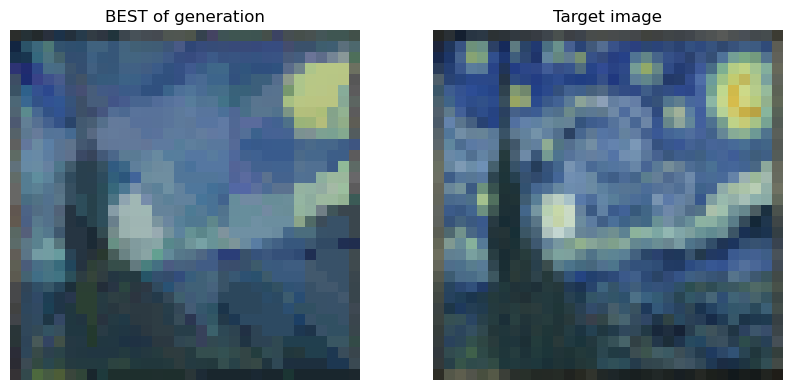

Gen (870) : best fitness = 282.1222327566673
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

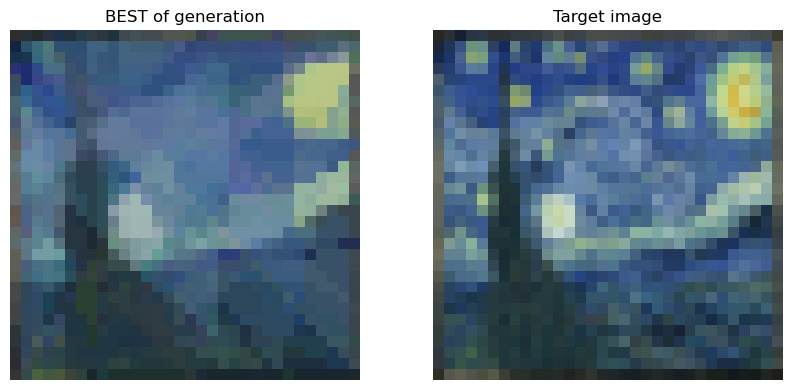

Gen (880) : best fitness = 281.6926560044094
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

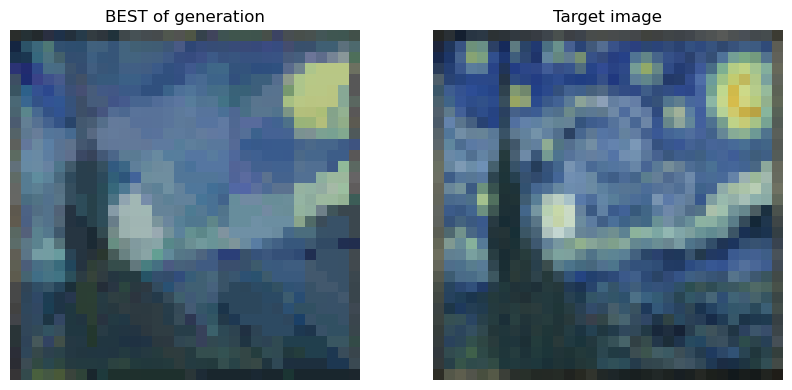

Gen (890) : best fitness = 281.3404169536432
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

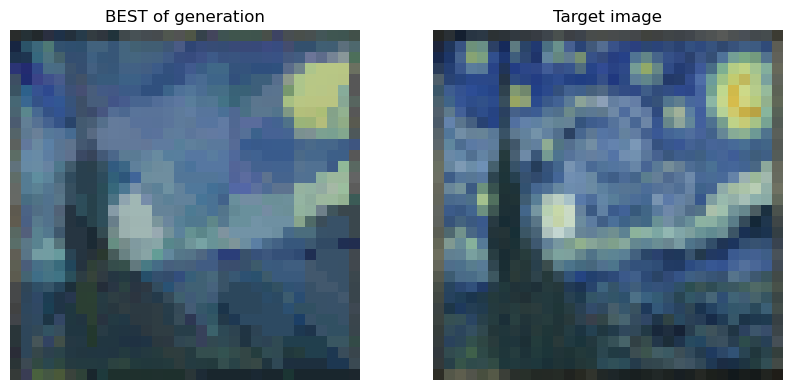

Gen (900) : best fitness = 280.57527368680627
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

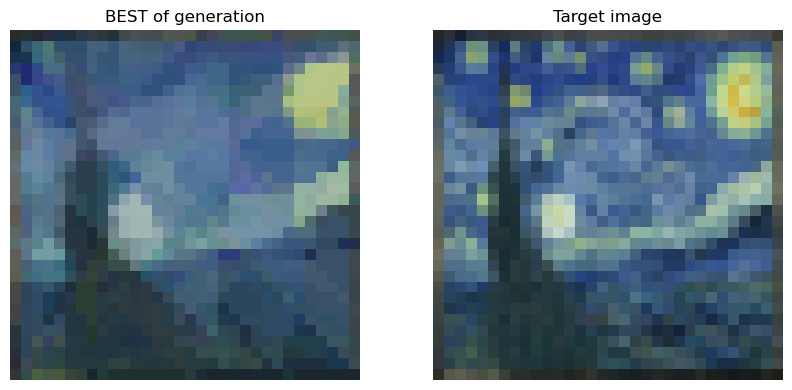

Gen (910) : best fitness = 280.2840975770676
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

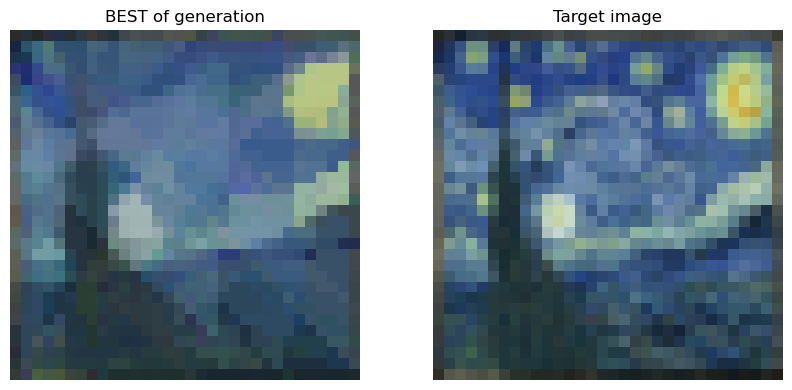

Gen (920) : best fitness = 279.8225407392926
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

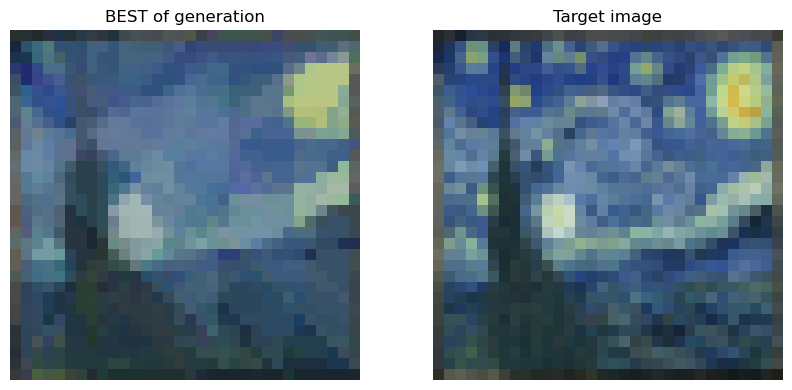

Gen (930) : best fitness = 279.34287352431767
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

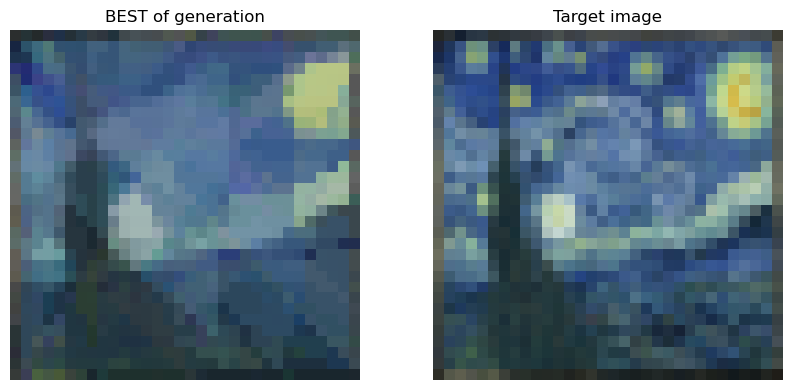

Gen (940) : best fitness = 279.0049241199395
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

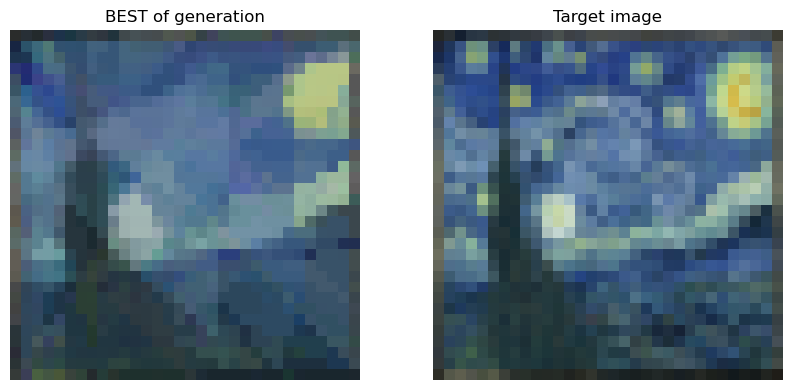

Gen (950) : best fitness = 278.7451640664441
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

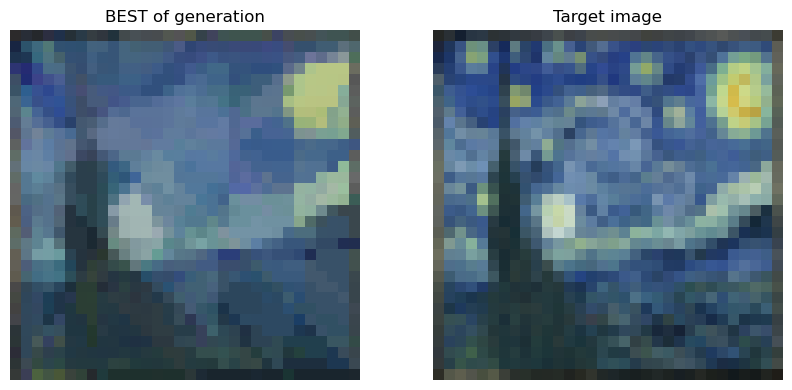

Gen (960) : best fitness = 278.3290033806599
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

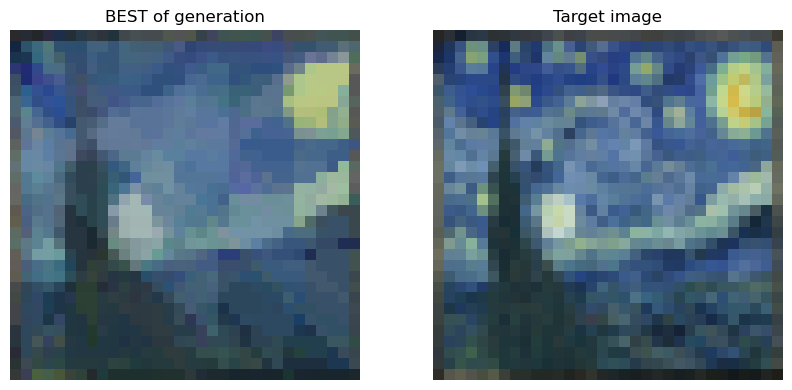

Gen (970) : best fitness = 278.0189621188318
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

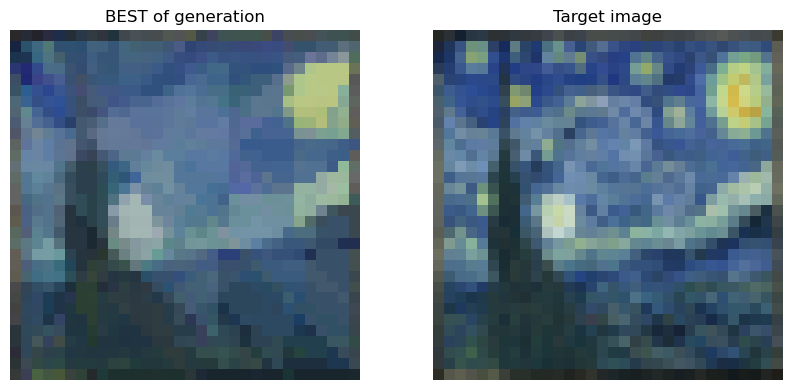

Gen (980) : best fitness = 277.7746478913422
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

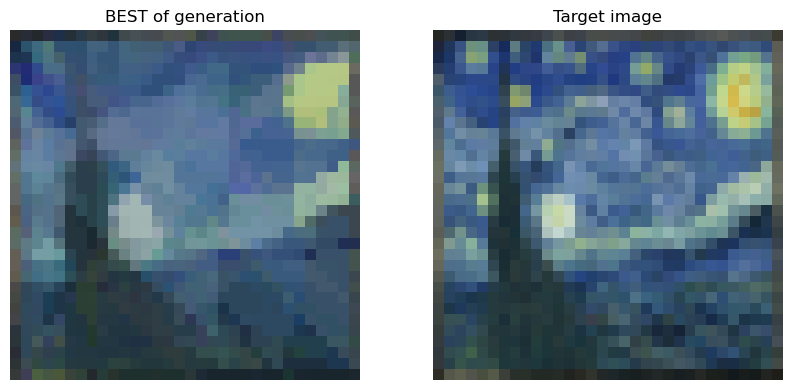

Gen (990) : best fitness = 277.52307475749234
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

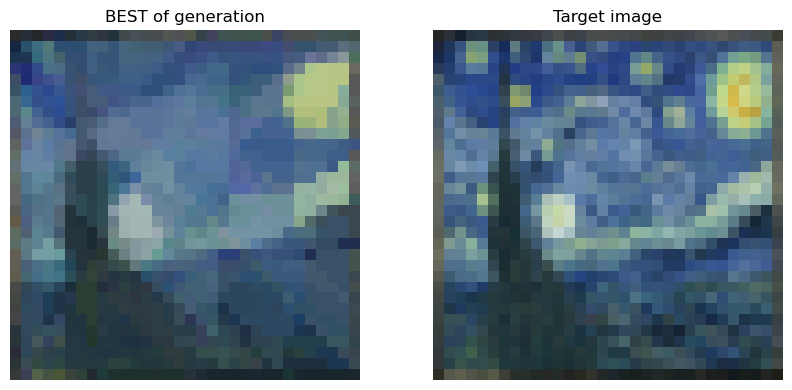

Gen (1000) : best fitness = 276.8676123071884
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

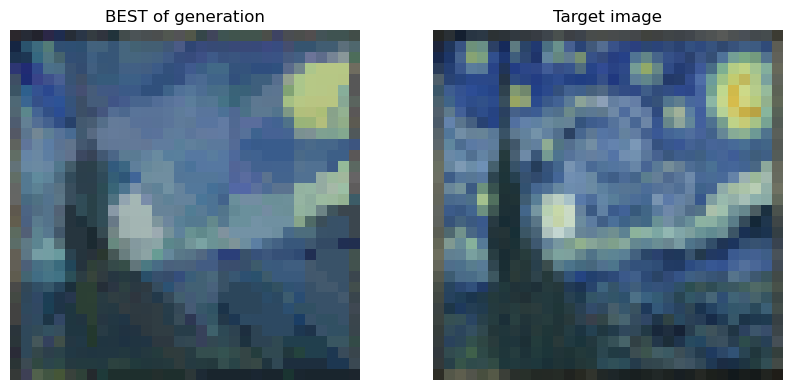

Gen (1010) : best fitness = 276.2163407496901
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

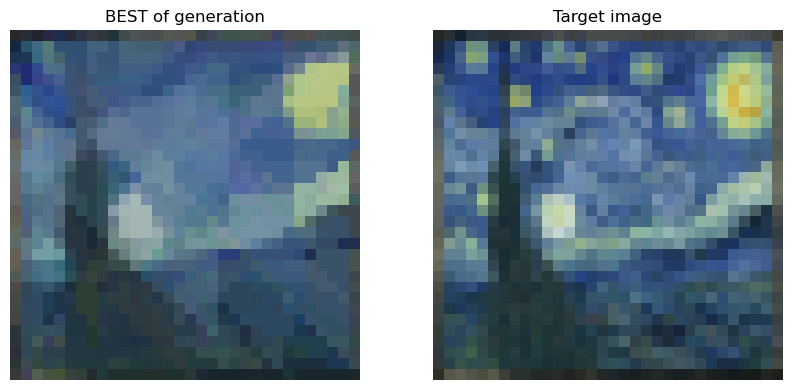

Gen (1020) : best fitness = 275.97349681359094
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

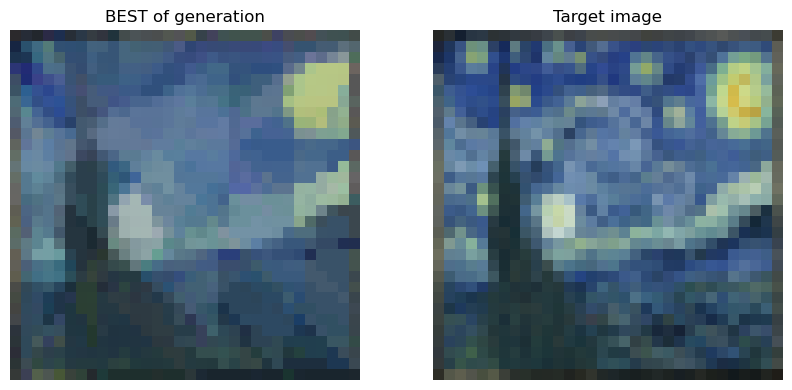

Gen (1030) : best fitness = 275.75993368014264
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

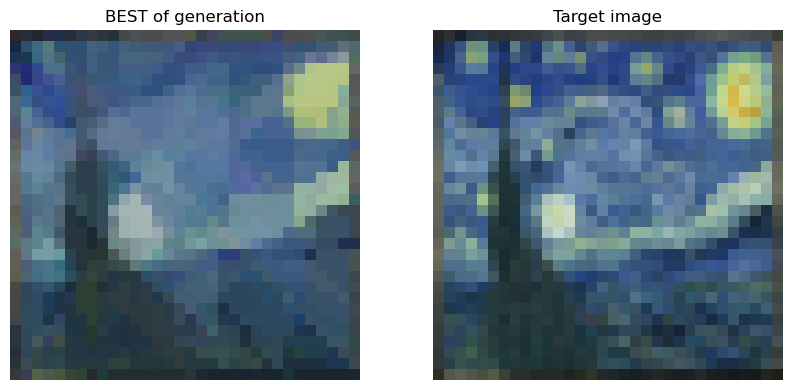

Gen (1040) : best fitness = 275.4653762060345
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

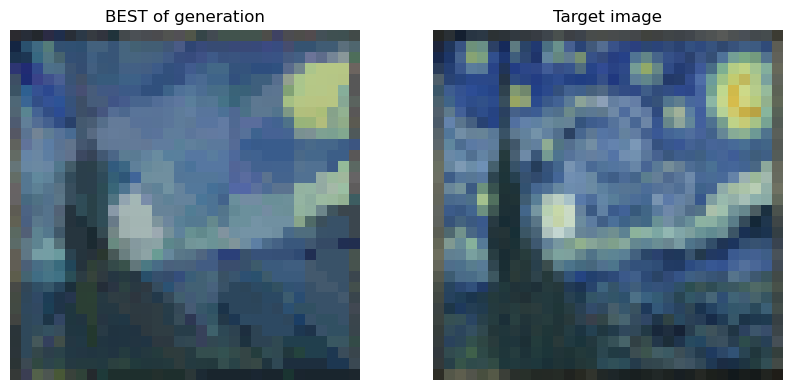

Gen (1050) : best fitness = 275.1966371189589
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

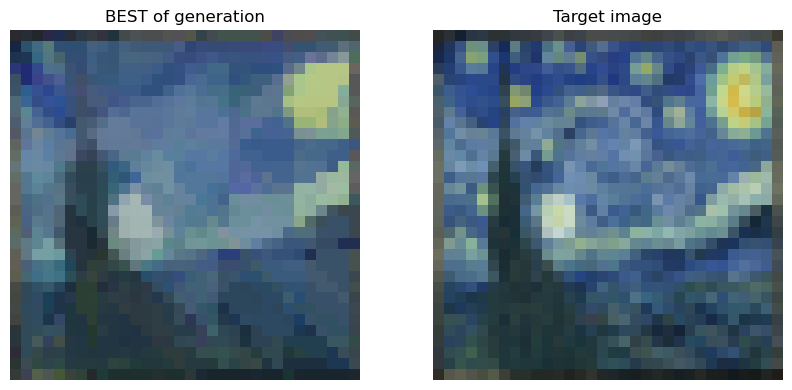

Gen (1060) : best fitness = 274.8595571708193
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

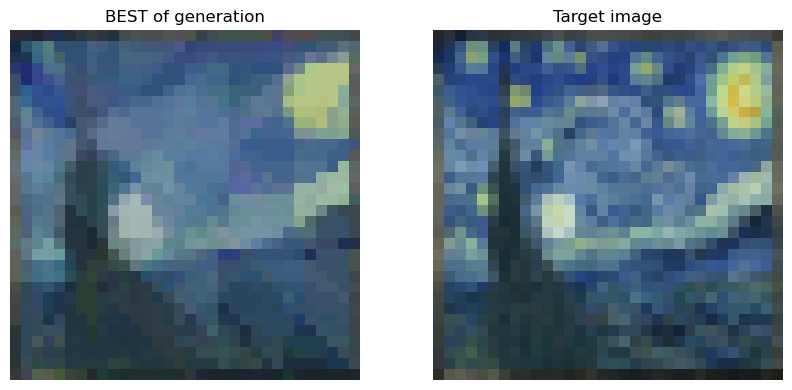

Gen (1070) : best fitness = 274.5288329610073
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

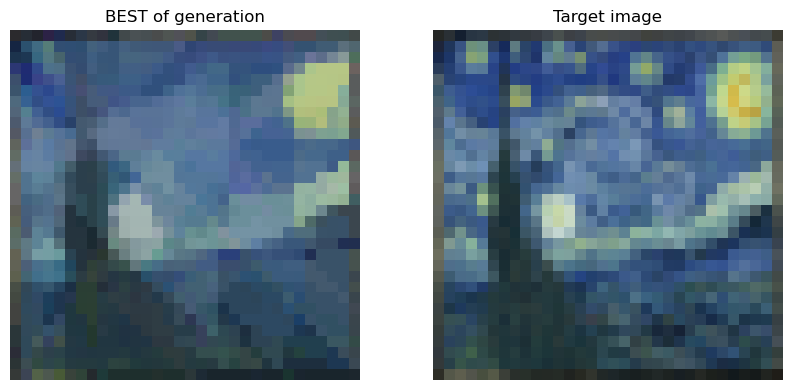

Gen (1080) : best fitness = 273.9944197529799
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

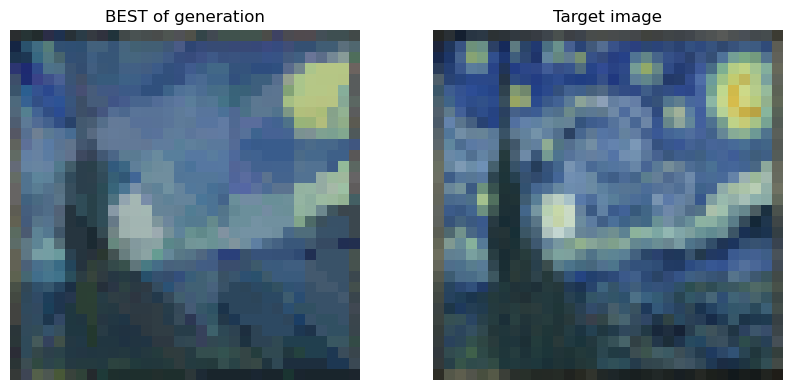

Gen (1090) : best fitness = 273.62185844710865
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

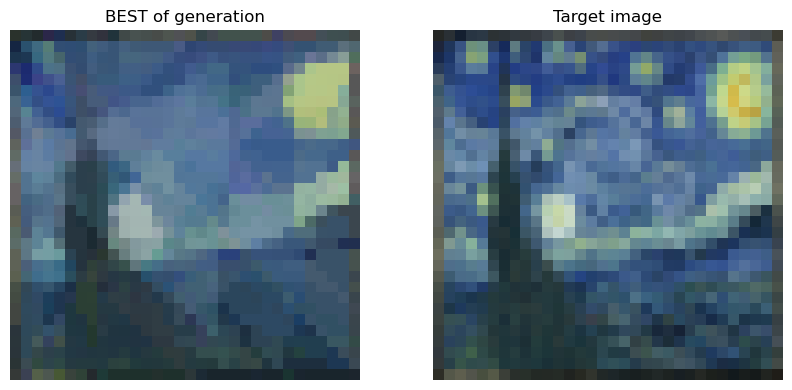

Gen (1100) : best fitness = 273.3968033119509
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

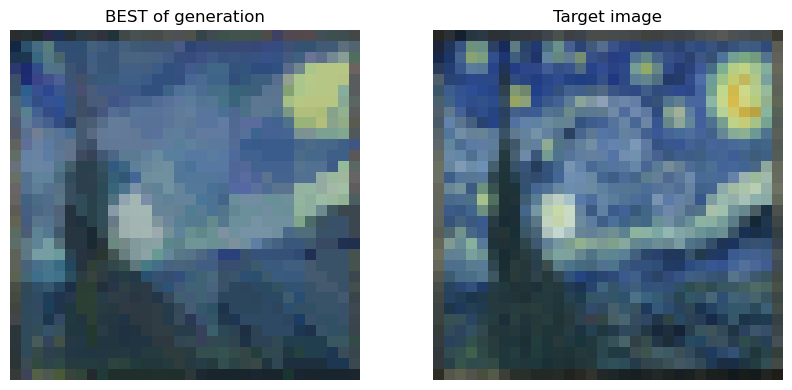

Gen (1110) : best fitness = 272.99783744823895
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

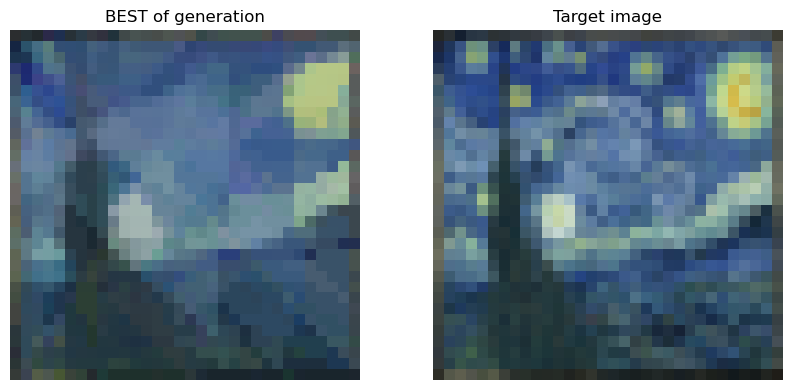

Gen (1120) : best fitness = 272.66243240790055
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

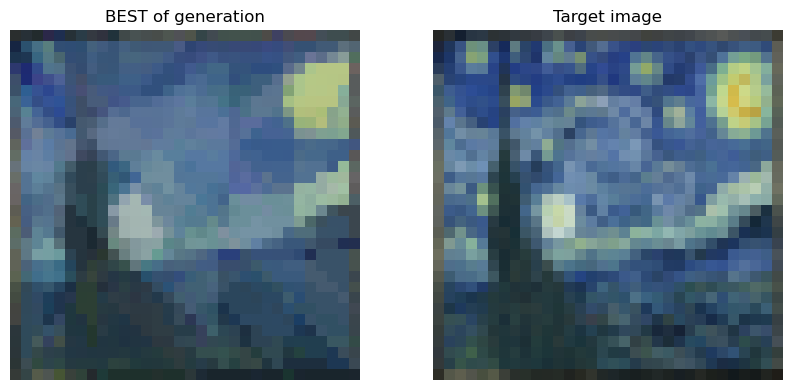

Gen (1130) : best fitness = 272.36265676573447
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

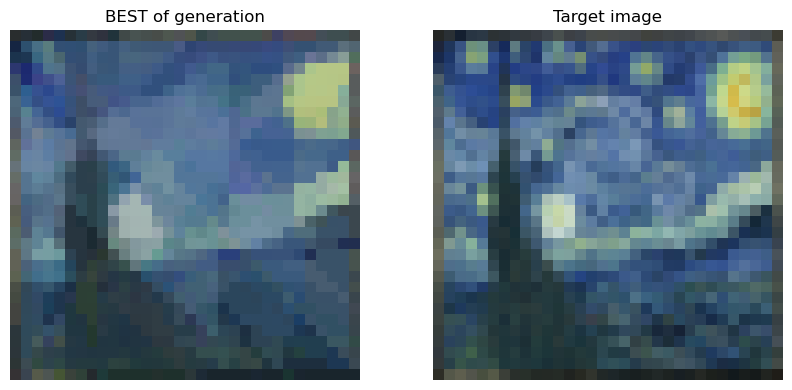

Gen (1140) : best fitness = 272.0346890878268
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

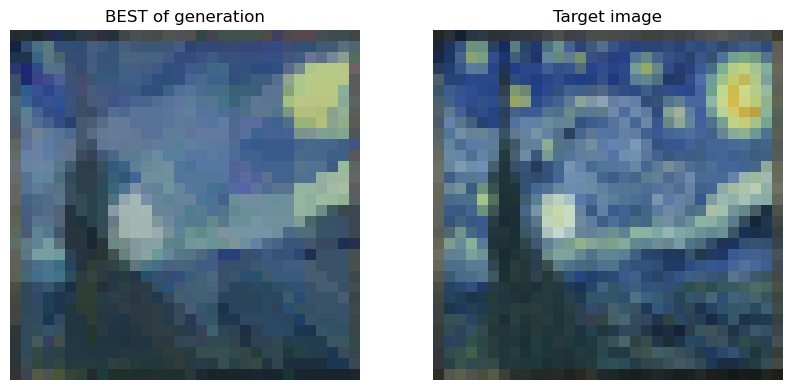

Gen (1150) : best fitness = 271.4331097140098
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

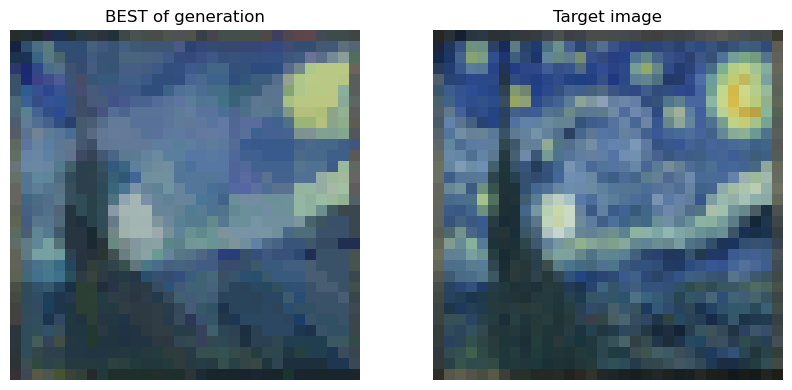

Gen (1160) : best fitness = 271.03613194691405
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

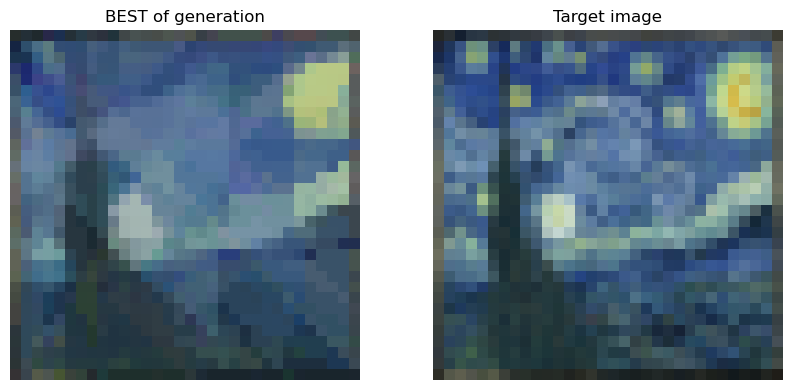

Gen (1170) : best fitness = 270.8686001675606
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

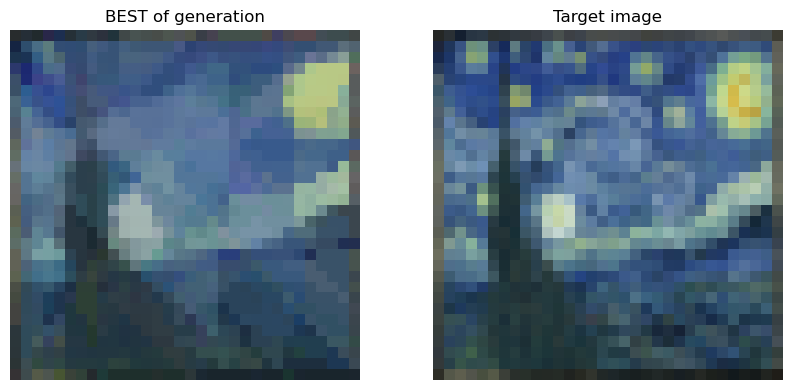

Gen (1180) : best fitness = 270.5572559280534
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

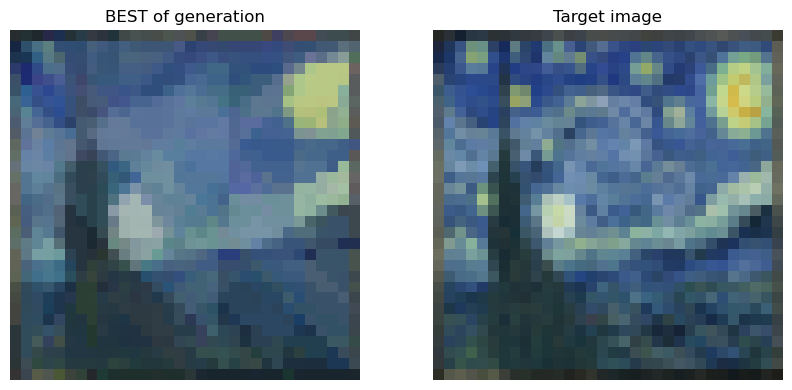

Gen (1190) : best fitness = 270.3522271994179
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

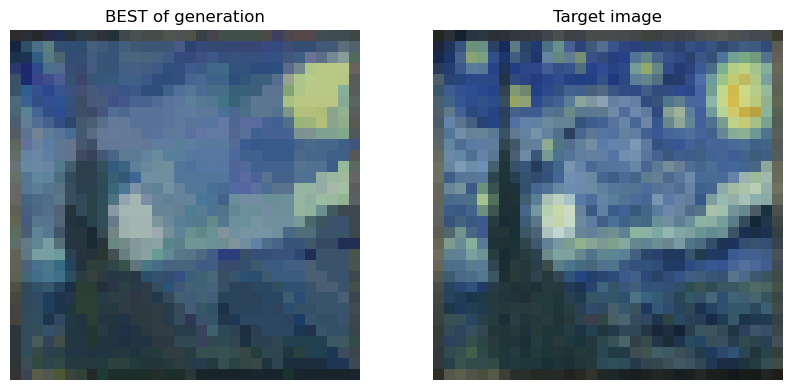

Gen (1200) : best fitness = 270.0501936507753
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

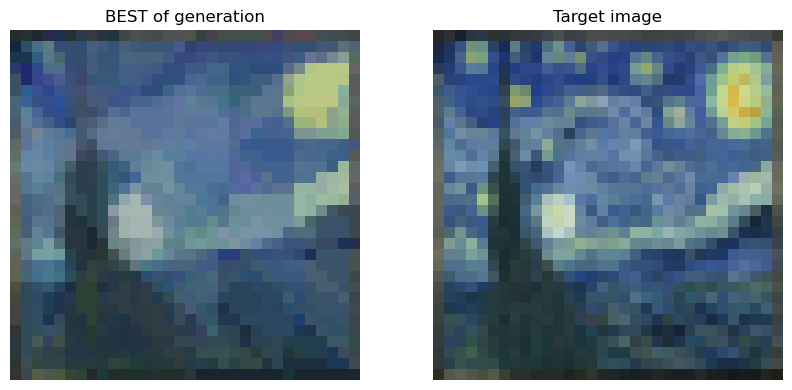

Gen (1210) : best fitness = 269.8500794915331
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

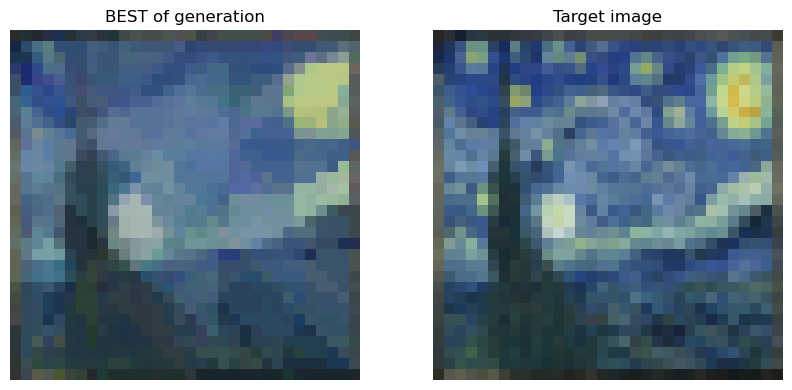

Gen (1220) : best fitness = 269.1811763093625
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

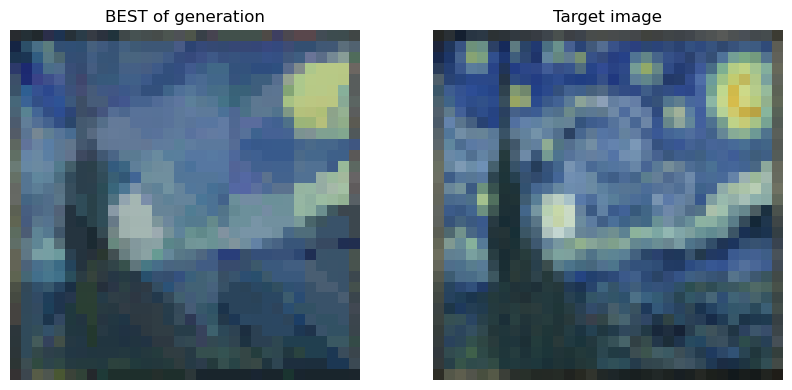

Gen (1230) : best fitness = 268.8909166020833
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

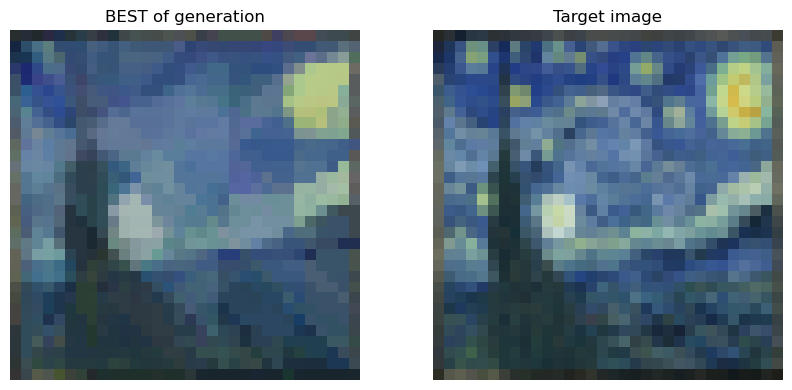

Gen (1240) : best fitness = 268.6827381006537
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

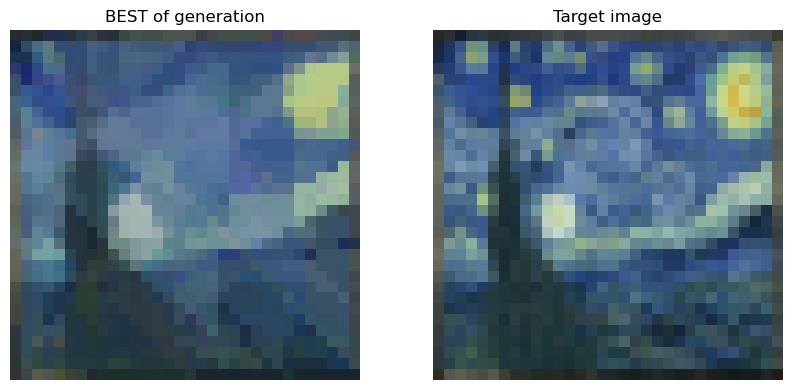

Gen (1250) : best fitness = 268.49177485486337
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

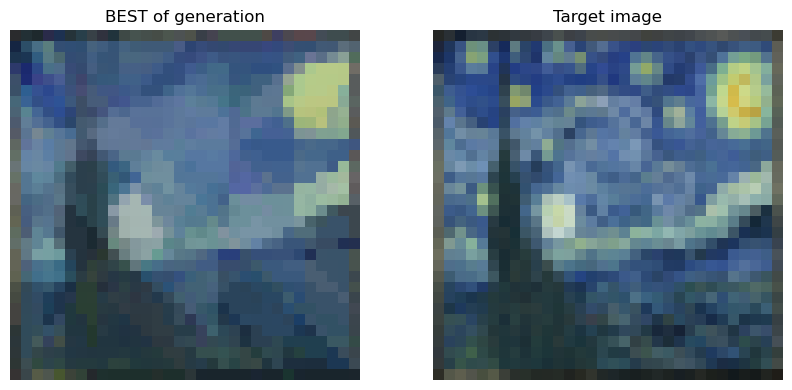

Gen (1260) : best fitness = 268.4033192947107
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

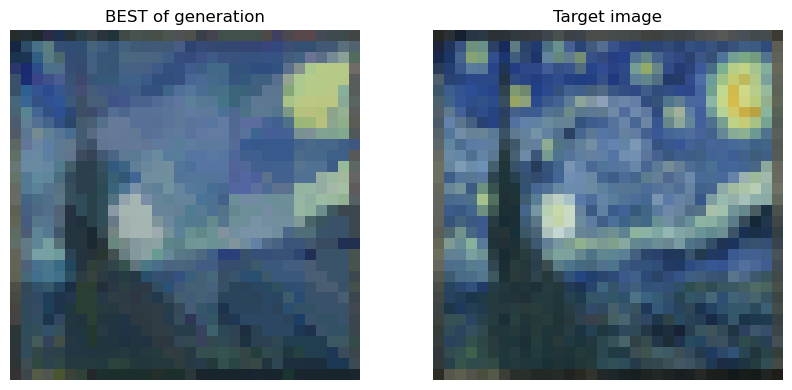

Gen (1270) : best fitness = 268.22197838844517
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

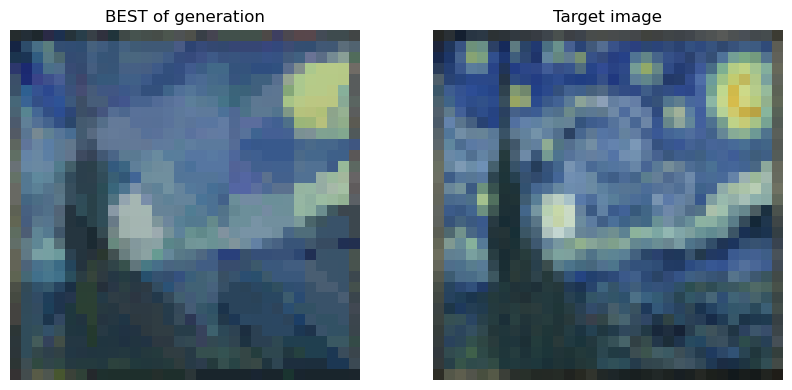

Gen (1280) : best fitness = 268.0584985646395
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

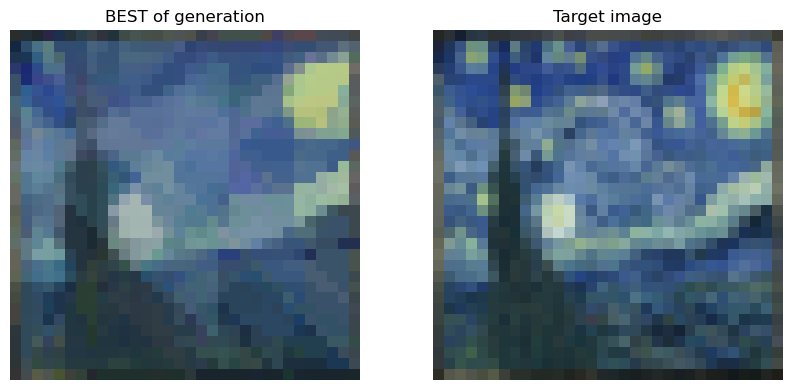

Gen (1290) : best fitness = 267.85596864949827
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

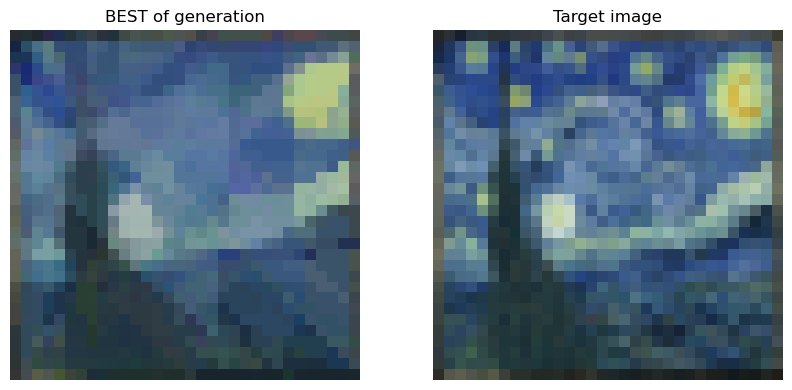

Gen (1300) : best fitness = 267.7133824131343
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

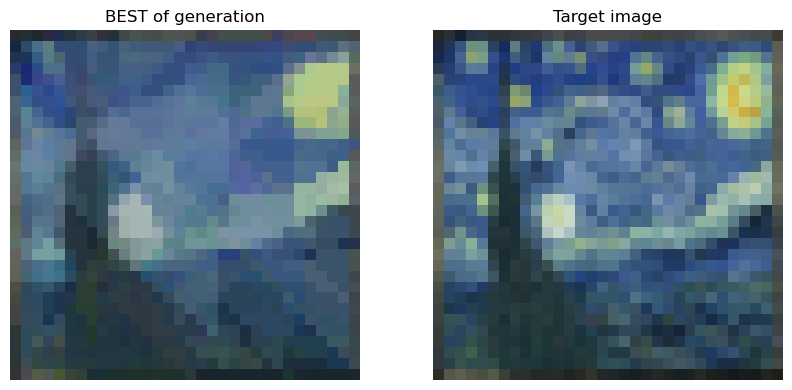

Gen (1310) : best fitness = 267.6858565537992
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

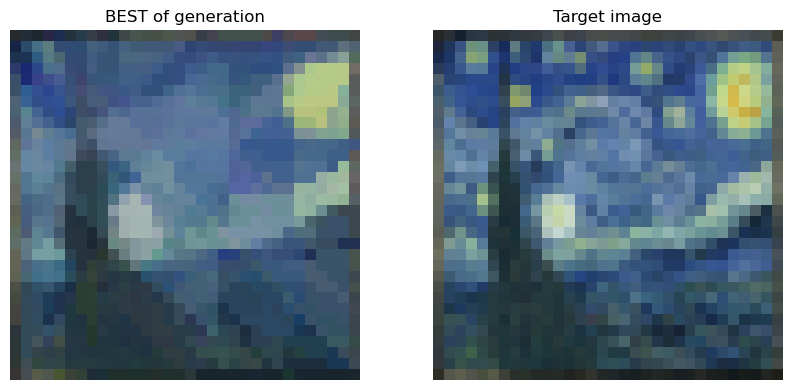

Gen (1320) : best fitness = 267.4033418815015
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

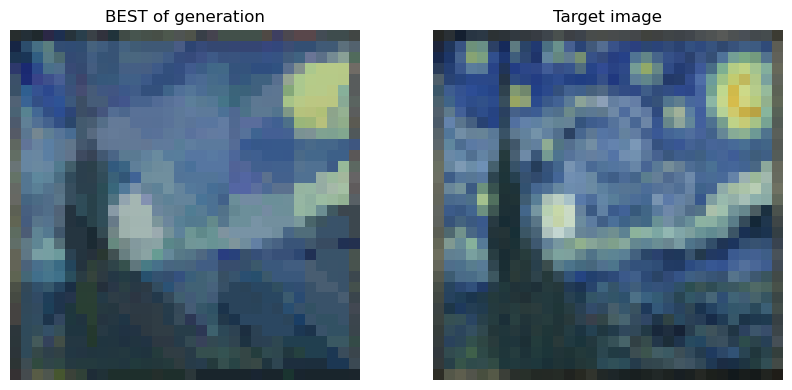

Gen (1330) : best fitness = 267.1407594884699
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

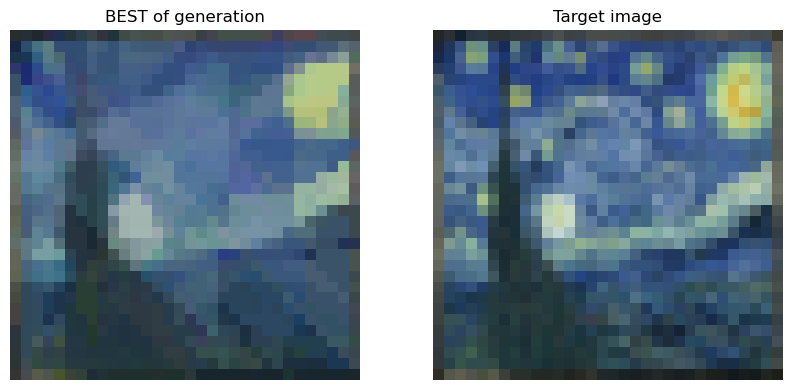

Gen (1340) : best fitness = 266.9947051676634
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

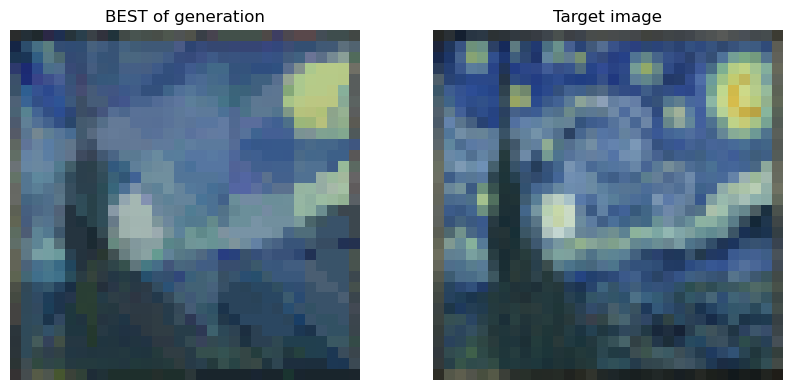

Gen (1350) : best fitness = 266.7441004171464
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

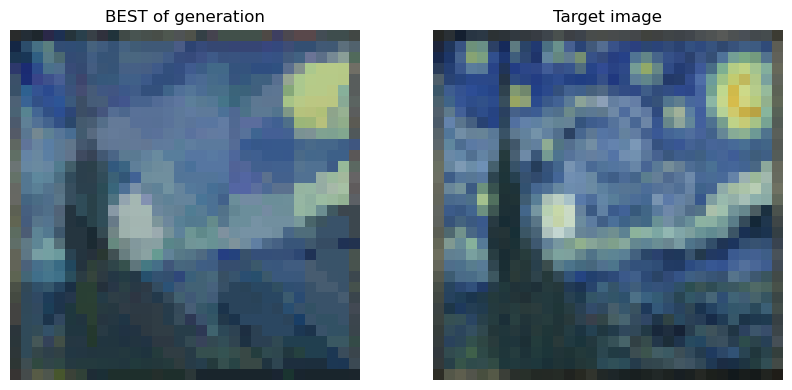

Gen (1360) : best fitness = 266.524203088771
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

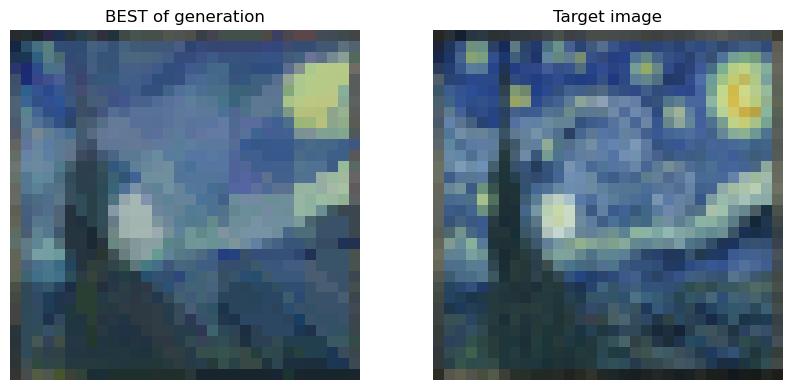

Gen (1370) : best fitness = 266.41156879254345
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

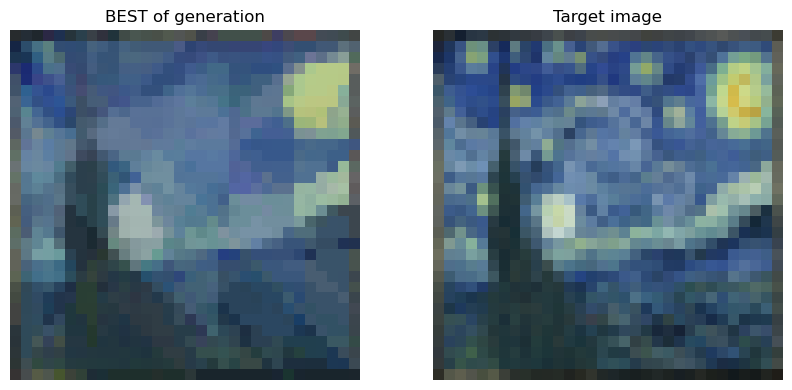

Gen (1380) : best fitness = 266.0827762999556
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

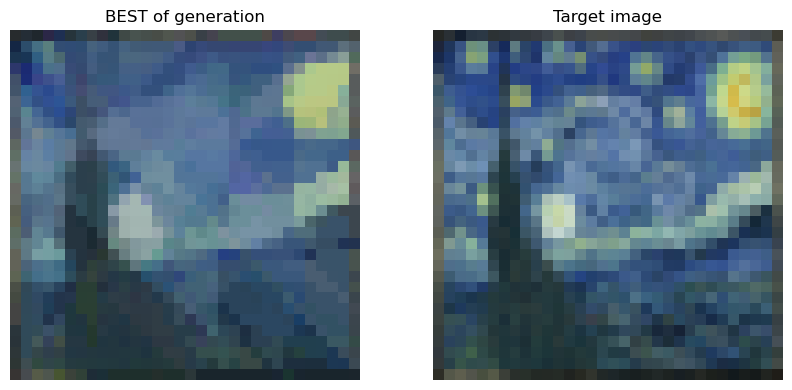

Gen (1390) : best fitness = 265.9752253355717
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

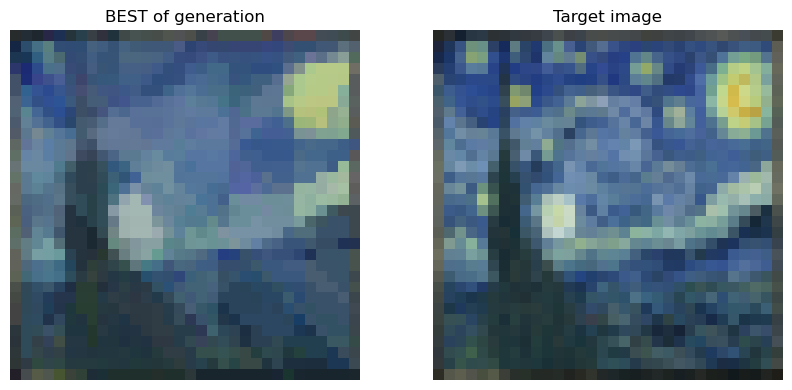

Gen (1400) : best fitness = 265.66547783883493
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

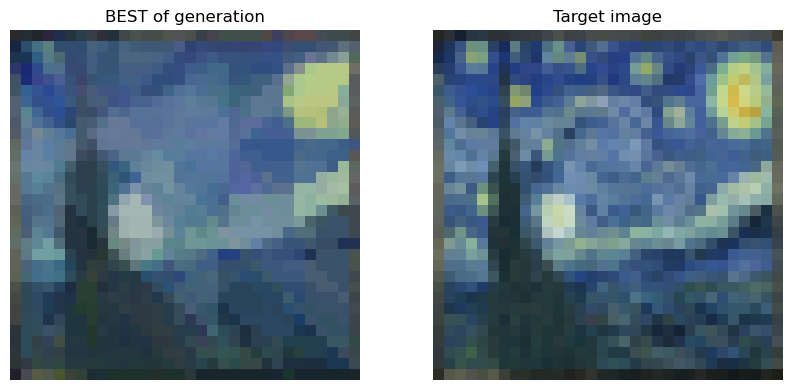

Gen (1410) : best fitness = 265.2611157494518
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

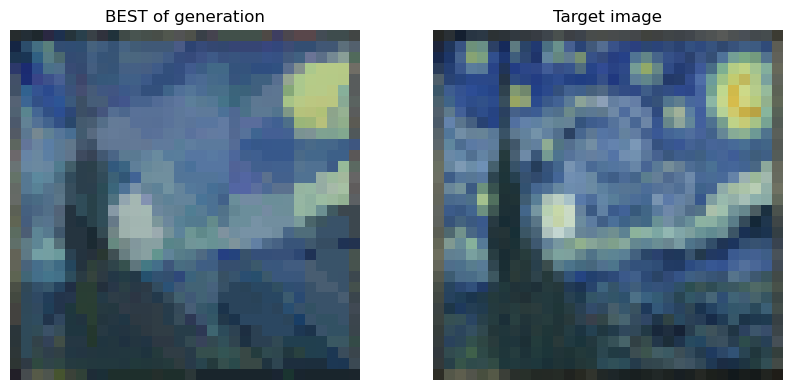

Gen (1420) : best fitness = 265.0327902764337
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

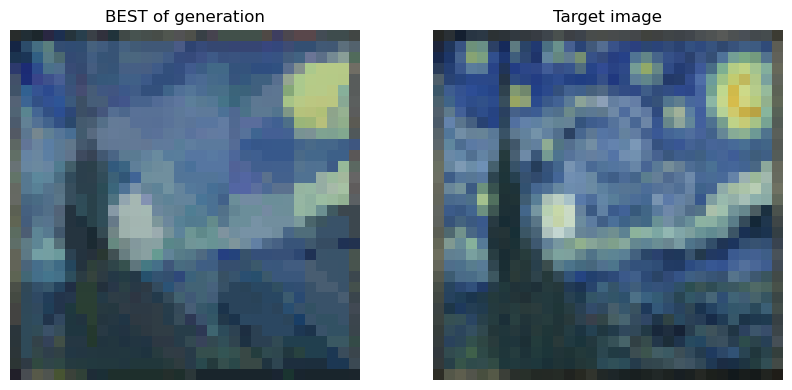

Gen (1430) : best fitness = 264.87196641740314
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

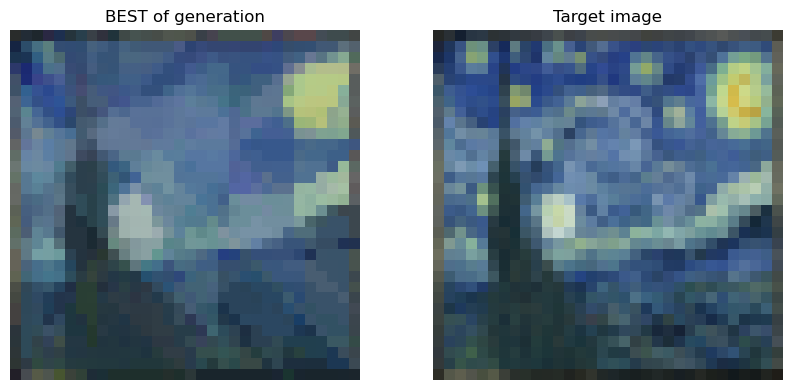

Gen (1440) : best fitness = 264.5729937419396
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

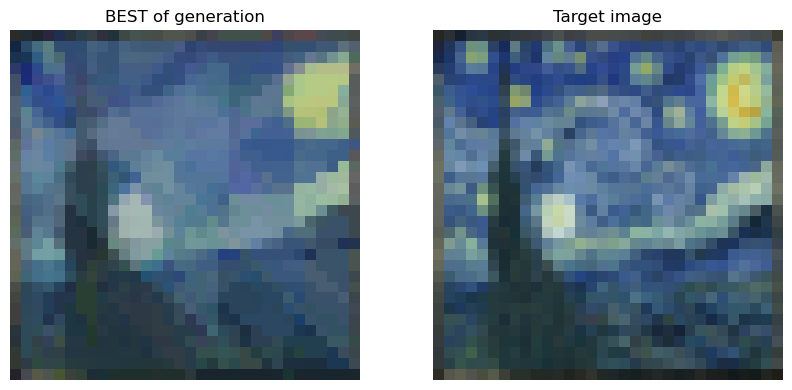

Gen (1450) : best fitness = 264.3303299686753
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

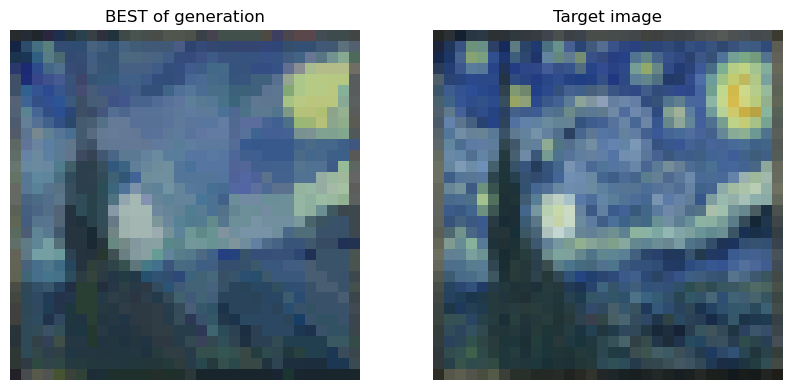

Gen (1460) : best fitness = 264.187298418361
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

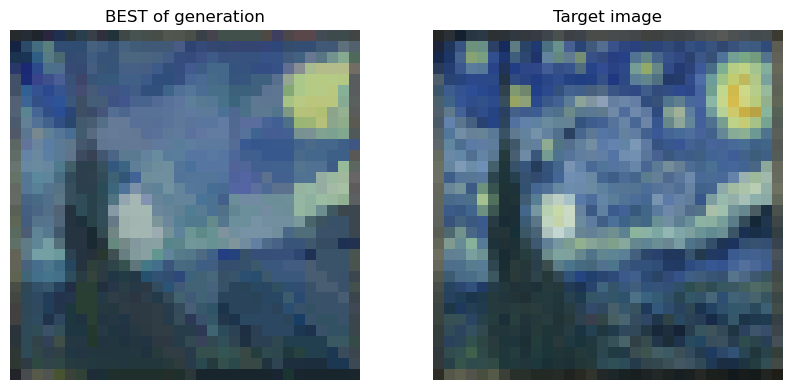

Gen (1470) : best fitness = 264.02098528134246
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

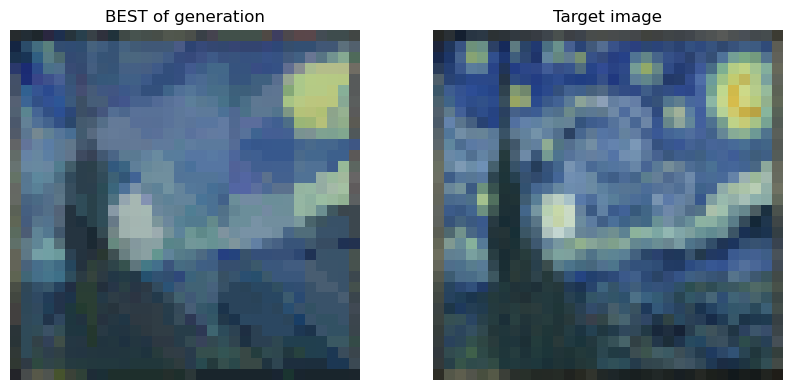

Gen (1480) : best fitness = 263.82923022344954
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

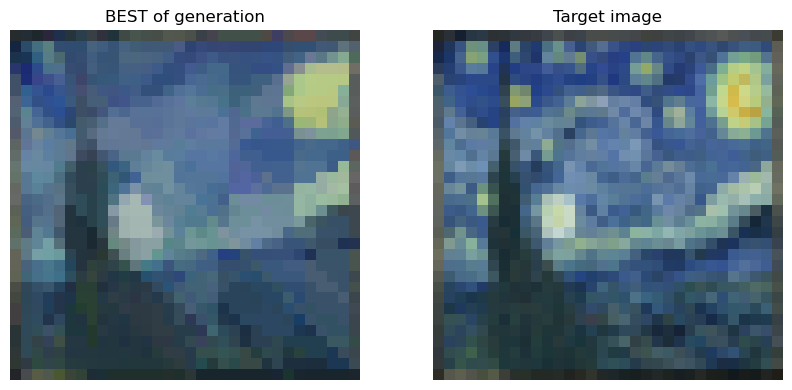

Gen (1490) : best fitness = 263.44156726742244
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

...........................................

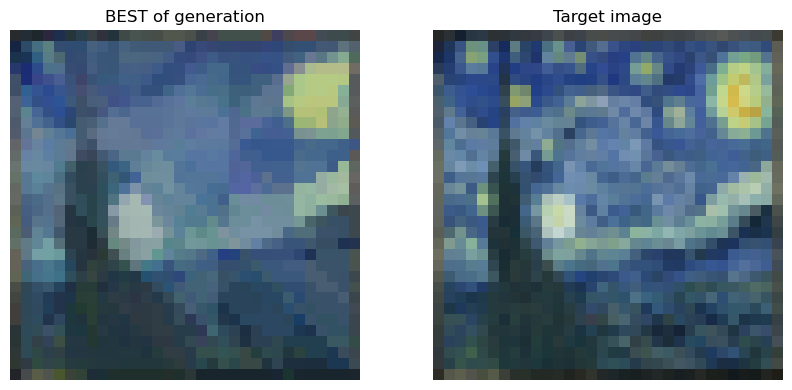

Gen (1500) : best fitness = 262.91445224078586
..................................................................................................................................................................................................................................

In [22]:
best = None
history = []

for g in range(NGEN):
    # clear_output(wait=True)  # Limpiar la salida antes de mostrar la nueva imagen y resultados
  
    pop, logbook = algorithms.eaMuCommaLambda(
        pop, toolbox, mu=MU, lambda_=LAMBDA, 
        cxpb = CXPB, mutpb=MUTPB, ngen=RGEN, stats=stats, 
        halloffame=hof, verbose=False
    )
  
    best = hof[0]

    render = render_individual(best)
    history.extend([clamp(0.0, 5000.0, l["min"]) for l in logbook])
    show_results(history, render, target)
    print(f"Gen ({(g+1)*RGEN}) : best fitness = {fitness_mse(render)}")
plt.show()